# Project 1: Sex Differences in brain organization

### Main Script: STRUCTURE-FUNCTION comparison

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
import math
from math import isnan
import statistics
import pingouin as pg
import pickle

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_gsp = '/data/p_02667/sex_diff_gradients/results/GSP/'
resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'

## Define functions

In [3]:
def fetch_all_sub_conn_matrices(path_conn_matrices):
    
    '''
    
    Function that fetches the connectivity matrices of all subjects from path and stores them in a variable 
    
    Input:
    - path containing all the subject connectivity matrices
    
    Output (dictionary containing):
    - conn_matrices: np array contianing the connectivty matrices of all subjects (in the form of 1 np array per subject)
    - sub_list: list containing all the subject IDs
    
    
    '''
    
    # list that contains all the subject IDs of subjects with fc matrices
    sub_list = []

    # list that contains the fc matrices of all subjects in the form of 1 np array per subject
    conn_matrices = []

    # reads (lists) the content of the path containing the list of fc_matrices and stores the sorted contents in as a list in the variable list_fc_matrices
    list_conn_matrices = os.listdir(path_conn_matrices)
    list_conn_matrices.sort()

    for e in list_conn_matrices:
        if '.csv' in e:  # need to do this because there is a hidden files in the path_list_fc_matrices

            # add subject to the subjects' list
            sub_list.append(e.partition(".")[0])  # this partitions the subID.csv into a 3-tuple containing ('subID', '.', 'csv'), and I keep only the subID

            # reads csv file in the form of an array
            sub_matrix = np.genfromtxt(path_conn_matrices + e, delimiter=',')

            # add subject's matrix to the fc_matrices_400 list
            conn_matrices.append(sub_matrix)

    print(f'Connectivity matrices found in path {path_conn_matrices}: N = {len(sub_list)}')
    
    dict_output = {'conn_matrices': conn_matrices, 'sub_list': sub_list}
    
    return dict_output

In [4]:
def compute_mean_gradients(mean_conn_matrix, display_output = True, data_reduction_algorithm = 'dm'):
    
    '''
    
    Function that computes the mean gradients from mean connectivity matrix (across subjects)
    
    Input:
    - mean_conn_matrix: variable containing mean connectivity matrix across subjects
    - display_output: True (default) or False - displays the plots specified below
    - data_reduction_algorithm: used to compute the gradients. Options: 'dm' (diffusion map embedding; default), 'le' (laplacian eigenmaps), 'pca' (principal component analysis)
    
    Output (display):
    - mean connectivity matrix + shape
    - 3 first mean connectivity gradients
    - scree plot of the variance explained by the 10 gradients + printed detail of variance explained and scaled varience explained
    
    Output:
    - mean_grad: the mean gradients, computed from the mean connectivity matrix with default parameters (diffusion map embedding, 10 gradients, normalized angle, threshold (fit -> sparsity = 0.90)
    
    
    '''  
    
    ## compute the mean gradients 
    
    # GradientMaps function used to build the model parameters
    mean_grad = GradientMaps(n_components = 10, random_state = 0, approach = data_reduction_algorithm, kernel = 'normalized_angle')

    # fit function used to compute the gradients
    mean_grad.fit(mean_conn_matrix)
    
    
    if display_output:
        
        ## plot the mean connectivity matrix and shape
        
        plt.imshow(mean_conn_matrix)
        plt.show()
        print(mean_conn_matrix.shape)
        
        
        ## plot the 3 first mean gradients
        
        # defining labeling scheme and mask
        labeling = load_parcellation('schaefer', scale=400, join=True)
        surf_lh, surf_rh = load_conte69()
        mask = labeling != 0

        # list containing placeholders (None) for the number of gradients I want to plot
        grad = [None] * 3

        for i in range(3):
            # map the gradient to the parcels
            grad[i] = map_to_labels((mean_grad.gradients_)[:, i], labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

        plot = plot_hemispheres(surf_lh, surf_rh, array_name=grad, embed_nb = True, size=(1200, 400), cmap='viridis_r', color_bar=True, label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'], zoom=1.55)
        display(plot)


        ## plot the variance explained by the 10 gradients

        fig, ax = plt.subplots(1, figsize=(5, 4))
        ax.scatter(range(mean_grad.lambdas_.size), mean_grad.lambdas_)
        ax.set_title("Variance explained by the 10 gradients")
        ax.set_xlabel('Component Nb')
        ax.set_ylabel('Eigenvalue')
        plt.show()

        print(f"Total amount of variance explained by the {len(mean_grad.lambdas_)} gradients (uncorrected sum lambdas): {sum(mean_grad.lambdas_):.2f}\n")

        # Scaled variance explained by individual gradients: lambda / total(i.e., sum lambdas) * 100 %
        print(f"Scaled variance explained by individual gradients:\nG1: {mean_grad.lambdas_[0]/sum(mean_grad.lambdas_)*100:.2f}%\nG2: {mean_grad.lambdas_[1]/sum(mean_grad.lambdas_)*100:.2f}%\nG3: {mean_grad.lambdas_[2]/sum(mean_grad.lambdas_)*100:.2f}%\n")

    
    return mean_grad

In [5]:
def compute_aligned_gradients(conn_matrices, mean_grad, data_reduction_algorithm = 'dm'):
    
    '''
    
    Function that computes the alligned gradients from all subject connectivity matrices
    
    Input:
    - variable containing all subject connectivity matrices
    - array including the mean connectivity gradients
    - data_reduction_algorithm: used to compute the gradients. Options: 'dm' (diffusion map embedding; default), 'le' (laplacian eigenmaps), 'pca' (principal component analysis)
    
    Output (dictionary containing arrays):  
    - array_aligned_gradients
    - array_aligned_G1
    - array_aligned_G2
    - array_aligned_G3
    
    Gradients computed from the mean connectivity matrix with default parameters (diffusion map embedding, 10 gradients, normalized angle, threshold (fit -> sparsity = 0.90)
    
    '''
    
    list_aligned_gradients = []  # will contain all participants (1014), all parcels (400), all gradients (10)
    list_aligned_G1 = []  # will contain all participants (1014), all parcels (400) -> values = loadings for GRADIENT 1
    list_aligned_G2 = []  # will contain all participants (1014), all parcels (400) -> values = loadings for GRADIENT 2
    list_aligned_G3 = []  # will contain all participants (1014), all parcels (400) -> values = loadings for GRADIENT 3

    # loop over all the connectivity matrices
    for i in range(len(conn_matrices)):
        # setting model parameters for gradients to be computed across subjects - with procrustes alignment
        grad_procr = GradientMaps(n_components=10, random_state=0, approach = data_reduction_algorithm, kernel='normalized_angle', alignment='procrustes')  # specify alignment method here (procrustes)

        # computing
        # note that by using an alignment method, .fit yields a variable (grad_procr) containing both types of gradients, callable with: .gradients_ (original) and .aligned_ 
          # use ._gradients for mean_grad (mean grad was not even calculated with a reference so doesn't have ._aligned) and use .aligned_ for grad_procr 

        grad_procr.fit(conn_matrices[i], reference=mean_grad)  # align to the gradients of the gradients produced by the mean matrix (reference) 

        # append array to lists results (.T is necessary in order to be able to first access the gradients layer (10) so that can index the desired gradient, which will then contain all the parcels (400)
        list_aligned_gradients.append(grad_procr.aligned_)
        list_aligned_G1.append(grad_procr.aligned_.T[0])
        list_aligned_G2.append(grad_procr.aligned_.T[1])
        list_aligned_G3.append(grad_procr.aligned_.T[2])

    # make gradient lists into arrays (for analyses)    
    array_aligned_gradients = np.array(list_aligned_gradients)
    array_aligned_G1 = np.array(list_aligned_G1)
    array_aligned_G2 = np.array(list_aligned_G2)
    array_aligned_G3 = np.array(list_aligned_G3)
        
        
    ### dictionary to output
    
    dict_output = {'array_aligned_gradients': array_aligned_gradients, 'array_aligned_G1': array_aligned_G1, 'array_aligned_G2': array_aligned_G2, 'array_aligned_G3': array_aligned_G3}
    
    
    return dict_output

In [6]:
def RainCloudPlot_YeoNetworks_SexComparison(array_grad, sex_comp = None):
    
    ''' 
    
    Function that produced RainCloud Plots of gradient loadings (mean across subjects for each parcel), color coded by Yeo network, compared across sexes
    
    The distribuitions by network (as displayed in different colors) show the differences between parcels belonging to the same network (because each point is 1 parcel; the mean is calculated across subjects for that parcel)
    -> emphasis is on displaying the gradient loadings of parcels belonging to the same network (spread of distribution -integration/segregation- of parcels belonging to the same network)
    
    
    Input:
    - array_grad: gradient array
    - sex_comp: variable used for sex comparison in list or series format
    
    Output (display):  
    - RainCloudPlot of mean gradient loadings across subjects per parcel, color coded by Yeo network, compard by sex

   
    '''
    
        
    ## format gradient array for plotting
    # for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column (y), and labels to be plotted in other columns (max 2: x (sex) and hue (coloring by Yeo network))

    # dataframe of gradient loadings (shape: sub (vertical) x parcels (horizontal))
    df_grad = pd.DataFrame(array_grad)

    # adding a column containing the labels for the sex comparison
    df_grad["sex"] = sex_comp.tolist()

    # separatating the dataframe into two dataframes containing only subjects of the given sex (because need to calculate mean across subjects for each parcel)
    df_grad_cat_M = df_grad[df_grad["sex"] == 'M']
    df_grad_cat_F = df_grad[df_grad["sex"] == 'F']

    # removing the label of sex for the moment because need to have only the parcels in the same column
    df_grad_cat_M = df_grad_cat_M.drop('sex', axis=1)
    df_grad_cat_F = df_grad_cat_F.drop('sex', axis=1)

    # transposing because we want the 400 parcels to be vertical in the dataframe in order to calculate mean by parcel
    df_grad_cat_M = df_grad_cat_M.T
    df_grad_cat_F = df_grad_cat_F.T

    # adding a column containing the mean gradient loading across subjects per parcel
    df_grad_cat_M['mean gradient loadings across subjects per parcel'] = df_grad_cat_M.mean(axis=1)
    df_grad_cat_F['mean gradient loadings across subjects per parcel'] = df_grad_cat_F.mean(axis=1)

    # adding a column containing the Yeo network labels
    df_grad_cat_M['yeo network'] = yeo7_networks_array_labels
    df_grad_cat_F['yeo network'] = yeo7_networks_array_labels

    # take a subset of the dataframes (only keep mean gradient loadings across subjects per parcels and yeo network labels, remove the individual subject values per parcel)
    df_grad_cat_M = df_grad_cat_M[["mean gradient loadings across subjects per parcel", "yeo network"]]
    df_grad_cat_F = df_grad_cat_F[["mean gradient loadings across subjects per parcel", "yeo network"]]

    # add label of sex for each dataframe before merging them in order to make males and females identifiable for plotting
    df_grad_cat_M['sex'] = 'M'
    df_grad_cat_F['sex'] = 'F'

    # concatenate the two datasets (by index in order to have rows = parcels from both datasets)
    df_to_plot = pd.concat([df_grad_cat_M, df_grad_cat_F], axis = 'index')



    ## plot 
    
    f,ax=plt.subplots(figsize=(20,15))

    ax=pt.RainCloud(x="sex",
                    y="mean gradient loadings across subjects per parcel",
                    hue="yeo network",
                    data=df_to_plot,
                    palette=palette_labeled_networks,
                    bw=.2,
                    width_viol=.6,
                    orient="h",
                    move=.2,
                    alpha=.65,
                    pointplot=True, 
                    dodge = True)
    

In [7]:
def RainCloudPlot_YeoNetworks_SexComparison_IndDiff(array_grad, sex_comp = None, plot_type = ['across sexes overlayed', 'across sexes separate', 'by sex overlayed', 'by sex separate']):
    
    ''' 

     --- don't use this function, only keeping it for reference for individual differences, but what I am using to understand results is function RainCloudPlot_YeoNetworks_SexComparison ---
     
     
    Function that produced Rain Cloud Plots of gradient loadings by Yeo network and optionally by sex 
    OLD function: the distribution by network shows the differences between subjects (because each point is 1 subject; the mean is calculated across parcels belonging to that same network) -> emphasis is on individual differences
     
    
    Input:
    - array_grad: gradient array
    - sex_comp: variable used for sex comparison in list or series format
    - plot_type: plot type display - should be one of the following 'across sexes overlayed', 'across sexes separate', 'by sex overlayed', 'by sex separate'
    
    Output (display):  
    - RainCloudPlot - display according to specified plot_type

   
    '''
    
    # defining conflicting inputted parameters - error messages
    if sex_comp is not None and plot_type == 'across sexes overlayed' or sex_comp is not None and plot_type == 'across sexes separate':
        print('ERROR: Conflicting inputted parameters - if you want across sexes, you must input sex_comp = None')
    
    elif sex_comp is None and plot_type == 'by sex overlayed' or sex_comp is None and plot_type == 'by sex separate':
         print('ERROR: Conflicting inputted parameters - if you want by sex, you must provide a variable for sex_comp')
            
    # if no conflicting parameters, can procede with formatting gradient array for plotting and plotting 
    else:
        
        ## format gradient array for plotting
        
        # dataframe of the G1 loadings (transposing the original array because we need the 400 parcels to be vertical in the dataframe in order to be labeled with their corresponding Yeo network)
        df_grad = pd.DataFrame(array_grad.T)

        # adding a column containing the Yeo network labels
        df_grad['yeo network'] = yeo7_networks_array_labels

        # obtaining the mean of the parcels with the same Yeo network label, then transposing because we need all subjects to be vertical (1 subject per row) in the dataframe in order to be labeled with their corresponding sex for comparison 
        df_grad = df_grad.groupby("yeo network", as_index=True).mean().T

        
        if sex_comp is None:
            df_grad["categorical comparison"] = [1] * len(df_grad)  # making a column of just 1s so that there is no categorical comparison to display (all subject belong in same group)
            
        else:    
            # adding a column containing the labels for the categorical comparison (according to inputted categorical variable
            df_grad["categorical comparison"] = sex_comp.tolist()

        # naming the index and resetting it as an index in order to make it callable in the following melt function
        df_grad.index.name = "sub"
        df_grad = df_grad.reset_index()

        # for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
        # using melt() to make dataframe long so that mean loadings per network are in one column, whilst preserving the sub number and sex as ID variables
        df_grad=pd.melt(df_grad, id_vars=["sub", 'categorical comparison'], var_name='yeo network', value_name='mean gradient loadings across parcels per subject')



        ## plot depending on requested plot type

        if plot_type == 'across sexes overlayed':
            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="categorical comparison",
                            y="mean gradient loadings across parcels per subject",
                            hue="yeo network",
                            data=df_grad,
                            palette=palette_labeled_networks,
                            bw=.2,
                            width_viol=.6,
                            orient="h",
                            move=.2,
                            alpha=.65,
                            pointplot=False, 
                            dodge = True)

        elif plot_type == 'across sexes separate':    
            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="yeo network",
                            y="mean gradient loadings across parcels per subject",
                            #hue="yeo network",
                            data=df_grad,
                            palette=palette_labeled_networks,
                            bw=.2,
                            width_viol=.6,
                            orient="h",
                            move=.2,
                            alpha=.65,
                            pointplot=False, 
                            dodge = True)


        elif plot_type == 'by sex overlayed':
            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="categorical comparison",
                            y="mean gradient loadings across parcels per subject",
                            hue="yeo network",
                            data=df_grad,
                            palette=palette_labeled_networks,
                            bw=.2,
                            width_viol=.6,
                            orient="h",
                            move=.2,
                            alpha=.65,
                            pointplot=True, 
                            dodge = True)


        elif plot_type == 'by sex separate':

            f,ax=plt.subplots(figsize=(20,15))

            ax=pt.RainCloud(x="yeo network",
                            y="mean gradient loadings across parcels per subject",
                            hue="categorical comparison",
                            data=df_grad,
                            palette=sns.color_palette(n_colors=2),
                            bw=.2,
                            width_viol=.6,
                            #figsize=(7,5),  # DELETE THIS
                            orient="h",
                            move=.2,
                            alpha=.65, 
                            dodge=True)

        else:
            print("ERROR: mis-specified plot_type. Please choose from: 'across sexes overlayed', 'across sexes separate', 'by sex overlayed', 'by sex separate'")


In [8]:
def plot_reg_results_R(reg_res):
    
    '''
    Function that plots regression results coming from R script (t-values, p-values, FDR corrected q-values, and t-values corresponding to sig FDR corrected q values)
    
    Input required: slm results dataframe containing vales with the following names: t_val_sex, p_val_sex, q_val_sex (*** HARCODED WITH "sex" IN NAME - CHANGE THIS TO SIMPLY t_val IF I START USING THIS VISUALIZATION FUNCTION FOR OTHER R RESULTS ***)
    
    Specific to plotting on surf_lh, surf_rh from conte69; for data coming from Schaefer 400 parcellation
    
    '''
    
    # defining labeling scheme and mask
    labeling = load_parcellation('schaefer', scale=400, join=True)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0
    
    
    # will contain the different plots
    handles = []
    
    
    ### t-values
    tvals_mapped_to_labels = map_to_labels(np.asarray(reg_res.t_val_sex), labeling, mask=mask, fill=np.nan)  # t[0] because there is a double bracket for the t-values array, need [0] to access the values themselves
    
    tvals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = tvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "bwr_r",  # bwr, _r stands for reversed; using it to match male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["t-values"],
        zoom = 1.45)
    
    # plot
    handles.append(tvals_plotted_hemispheres)
       
        
    
    ### p-values (uncorrected)
    
    #assigning to new variable using copy() so that changes made in copy will not affect the original array
    pvals = np.asarray(reg_res.p_val_sex.copy())

    # only keep Q-values that are significant (replacing values > 0.05 with nan)
    np.place(pvals, pvals > 0.05, np.nan) 
    
    # this maps shape (400,) turning it inot shape (64984,)
    pvals_mapped_to_labels = map_to_labels(pvals, labeling, mask=mask, fill=np.nan)
    
    # plot
    pvals_plotted_hemispheres =  plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = pvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "plasma_r", 
        color_bar = True, 
        #color_range = color_range_Q,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["p-values (uncorr.)"],
        zoom = 1.45)
    
    handles.append(pvals_plotted_hemispheres)    
        
        
                   
    ### Q-values
    
    #assigning to new variable using copy() so that changes made in copy will not affect the original array
    Qvals = np.asarray(reg_res.q_val_sex.copy())

    # only keep Q-values that are significant (replacing values > 0.05 with nan)
    np.place(Qvals, Qvals > 0.05, np.nan) 
    
    # this maps shape (400,) turning it inot shape (64984,)
    Qvals_mapped_to_labels = map_to_labels(Qvals, labeling, mask=mask, fill=np.nan)
    
    # plot
    Qvals_plotted_hemispheres =  plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = Qvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "plasma_r", 
        color_bar = True, 
        #color_range = color_range_Q,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["Q-values"],
        zoom = 1.45)
    
    handles.append(Qvals_plotted_hemispheres)
    
    
    ### t-values (only FDR-corrected) showing sex differences
    
    ## find t-values
    fdr_corrected_tvals = []
    
    for i in range(len(reg_res.q_val_sex)):
        if reg_res.q_val_sex[i] <= 0.05:
            fdr_corrected_tvals.append(reg_res.t_val_sex[i])
        else:
            fdr_corrected_tvals.append(float('nan'))
    
    fdr_corr_tvals_mapped_to_labels = map_to_labels(np.asarray(fdr_corrected_tvals), labeling, mask=mask, fill=np.nan)
    
    fdr_corr_tvals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = fdr_corr_tvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "bwr_r",  # bwr, _r stands for reversed; using it to match male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["t-values"],
        zoom = 1.45)
    
    # plot
    handles.append('t-values for FDR-corrected q < 0.05: (male: blue, female: red)')  # title
    handles.append(fdr_corr_tvals_plotted_hemispheres)
    
                                           
    return handles

In [9]:
def regression_contrast_results_breakdown_by_network(reg_res, contrast_type, scatterplot = True, scatter_x = None, scatter_y = None, scatter_x_label = None, scatter_y_label = None):
    
    '''
    
    Function that outputs the breakdown of regression contrast results by network 
    
    Input:
    - reg_res: regression results (in fomrat: DataFrame, containing columns 'q_val_sel' and 't_val_sex', len = 400 parcels (Schaeffer400))
    - contrast type: string indicating the contrast that is being studied, e.g., 'sex' (for plot titles)
    - scatter_x: x-axis of the scatterplot G1 vs G2 -> so G1 or G2 from mean gradient (in array format)
    - scatter_y: y-axis of the scatterplot G1 vs G2 -> so G1 or G2 from mean gradient (in array format)
    
    Output (display):  
    - written breakdown (number and proportion of significant parcels by network (relative proportion (i.e., out of all the parcels belonging to a given network) and absolute proportion (i.e., out of the total significant results)
    - plotted breakdown (pie chart) - proportion of significant parcels by network (absolute proportion)
    - plotted breakdown by sex (nested pie chart) - proportion of significant parcels by network (absolute proportion) by sex <- !!! HARDCODED M vs F labels !!!
    - Violin plot of t-values (regression results) by Yeo network
    - scatter plot showing of G1 vs G2, displaying parcels showing a significant contrast in dark
   
    '''
    
    ### written breakdown
    
    # counting number of significant parcels 
    # storing the Q values in a list (where non significant Q values are marked as 1 -> for later potential scatterplot visualization)
    # making a dictionary that counts the number of significant parcels per yeo network
    # making dictionaries that count the number of significant parcels per yeo network by sex

    sig_Q_vals_slm = []
    count_sig = 0
    count_sig_M = 0
    count_sig_F = 0
    count_sig_per_network = {"visual": 0, "sensory motor": 0, "DMN": 0, "dorsal attention": 0, "ventral attention": 0, "limbic": 0, "fronto parietal": 0}
    count_sig_per_network_bysex = {"visual": [0, 0], "sensory motor": [0,0], "DMN": [0,0], "dorsal attention": [0,0], "ventral attention": [0,0], "limbic": [0,0], "fronto parietal": [0,0]} # M: [0], F: [1]
    
    for i in range(len(reg_res.q_val_sex)):

        if reg_res.q_val_sex[i] < 0.05:
            count_sig += 1
            count_sig_per_network[yeo7_networks_array_labels[i]] += 1
            sig_Q_vals_slm.append(1)
            
            # positive t-values mean male > female: increment the first item of the list fort given label
            if reg_res.t_val_sex[i] > 0:  
                count_sig_M += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[i]][0] += 1
           
            # positive t-values mean female > male: increment the second item of the list for the given label
            else:
                count_sig_F += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[i]][1] += 1
            
            
        else:
            sig_Q_vals_slm.append(0)

    print(f"Number of significant parcels: {count_sig}\n")
    print(f"Number of significant parcels for males: {count_sig_M}")
    print(f"Number of significant parcels for females: {count_sig_F}\n")
    print("Number of significant parcels in each Yeo network (across sexes):")

    # using ANSI escape sequences to underline -> bold: \033[1m ; underline: \033[4m ; end: \033[0m
    for i in range(len(count_sig_per_network)):
        print(f"- {list(count_sig_per_network.keys())[i]}: \033[4m{count_sig_per_network[list(count_sig_per_network.keys())[i]]}\033[0m out of {yeo7_networks_array_labels.tolist().count(network_names[i])} ({round(count_sig_per_network[list(count_sig_per_network.keys())[i]] / yeo7_networks_array_labels.tolist().count(network_names[i]) * 100, 2)}%) -> \033[1m{round(count_sig_per_network[list(count_sig_per_network.keys())[i]]*100/count_sig,2)}%\033[0m of overall significance")
       
    print("\n\n")
    
    
    
    
    ### plotted breakdown (pie chart)
        
    # setting figure size
    fig, ax = plt.subplots(1, figsize=(10, 7))

    # data to plot: in dictionary count_sig_per_network
    network_labels = []
    data = []

    for x, y in count_sig_per_network.items():
        network_labels.append(x)
        data.append(y)

    # define color palette to use
    color_palette =[(227/255, 174/255, 211/255),  # color palette matching the raincloudplot colors (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt
                    (185/255, 163/255, 204/255),
                    (120/255, 162/255, 189/255),
                    (236/255, 170/255, 119/255),
                    (174/255, 147/255, 143/255),
                    (216/255, 128/255, 129/255),
                    (128/255, 183/255, 126/255)]
    
    # color_palette = sns.color_palette('pastel')[0:7]  # seaborn pastel color palette

    # plot pie chart
    ax.pie(data, 
           labels = network_labels, colors = color_palette, autopct='%.0f%%', 
           wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
           textprops={'fontsize': 16})

    ax.set_title(f'Breakdown of parcels by network showing a statistically significant {contrast_type} difference in gradient loadings', fontsize=18)

    # display
    ax.axis('equal')
    plt.tight_layout()
    
    
    
    
    ### Nested pie chart

    # make data plottable
    
    list_count_sig_per_network_bysex = []

    for label in count_sig_per_network_bysex:
        list_count_sig_per_network_bysex.append(count_sig_per_network_bysex[label])

        
    # plot
    
    fig, ax = plt.subplots(figsize=(15, 10))
    size = 0.3

    vals = np.array(list_count_sig_per_network_bysex)

    outer_colors = ["mediumvioletred",  # visual
                    "darkmagenta",  # sensorimotor
                    "steelblue",  # dmn
                    "darkorange",  # dorsal attention
                    "saddlebrown",  # ventral attention
                    "firebrick",  # limbic              
                    "green"]  # frontoparietal

    inner_colors = ['pink', 'lavenderblush',  # visual
                    'orchid', 'plum',  # sensorimotor
                    'lightskyblue', 'lightblue',  # dmn
                    'sandybrown', 'bisque',  # dorsal attention
                    'chocolate', 'peru',  # ventral attention
                    'lightcoral', 'salmon',  # limbic
                    'mediumseagreen', 'mediumaquamarine']  #frontoparietal

    ax.pie(vals.sum(axis=1), radius=1, labels=count_sig_per_network_bysex.keys(), colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='white'))

    ax.pie(vals.flatten(), radius=1-size, labels=['M','F']*len(list_count_sig_per_network_bysex), colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='white'))

    ax.set(aspect="equal")
    ax.set_title(f'Breakdown of parcels by network showing a statistically significant {contrast_type} difference in gradient loadings, by {contrast_type}', fontsize=18)

    plt.show()
    
    print('Number of significant parcels by sex:')
    for network in count_sig_per_network_bysex:
        print(f"{network} - Male: {count_sig_per_network_bysex[network][0]}, Female: {count_sig_per_network_bysex[network][1]}")
    
    print("\n\n")
    
    
    ### Violin plot of t-values (regression results) by Yeo network
    
    print("Violin plot of t-values (regression results) by Yeo network")

    df_to_plot = pd.DataFrame(reg_res.t_val_sex)

    df_to_plot['yeo network'] = yeo7_networks_array_labels

    # color palette matching the raincloudplot colors (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt

    color_palette =[(227/255, 174/255, 211/255),  # visual
                    (185/255, 163/255, 204/255),  # sensory motor
                    (236/255, 170/255, 119/255),  # dorsal attention
                    (174/255, 147/255, 143/255),  # ventral attention
                    (216/255, 128/255, 129/255),  # limbic
                    (128/255, 183/255, 126/255),  # fronto parietal
                    (120/255, 162/255, 189/255)]  # DMN

    fig, ax = plt.subplots(figsize = (15,5));
    ax = sns.violinplot(data=df_to_plot, 
                        x="yeo network", 
                        y="t_val_sex",
                        #hue="",
                        palette = color_palette,

                  )
    
    
    
    ### plot of significant parcels on G1 vs G2 visualization
    # problems with this plot
        # hard-coded axes labels and title (G1 vs G2)
        # legend of colors: showing 0 vs 1 
    if scatterplot:
    
        fig, ax = plt.subplots(figsize = (6,5));
        ax = sns.scatterplot(x = scatter_x, 
                             y = scatter_y,
                             hue = sig_Q_vals_slm,  # gives color coding based on Q value of sex contrast (main model including age, sex, icv) -> dark color: significance
                             palette = sns.color_palette(["lavender", "navy"]),
                             legend = True, ax = ax);

        ax.set_xlabel(scatter_x_label);
        ax.set_ylabel(scatter_y_label);
        ax.set_title(f'Scatter plot of G1 vs G2, showing significant {contrast_type} contrast in dark')
        ax.spines['right'].set_visible(False);
        ax.spines['top'].set_visible(False);
        #plt.legend(title='1 = FDR-corr significance')
        plt.show(ax)
        
        

In [10]:
def print_plot_corr_networks(x, y, x_label, y_label):
    
    '''
    
    
    Output:
    - correlations between 2 variables, both overall and per network
    - scatterplots colorcoded by yeo network, with regression lines per network
    
    
    '''
    
    ### creating a dataframe in order to have the data in the correct format to be plotted
    temp_dict = {x_label: x, y_label: y, 'yeo_network': yeo7_networks_array_labels}  
    dataframe = pd.DataFrame(data = temp_dict)
    

    ### print overall correlation
    print(f"Overall Pearson correlation between {x_label} and {y_label}: r = {round(stats.pearsonr(dataframe[x_label], dataframe[y_label])[0], 2)}; p = {round(stats.pearsonr(dataframe[x_label], dataframe[y_label])[1], 3)}\n")
    
    
    network_labels = ['visual', 'sensory motor', 'dorsal attention', 'ventral attention', 'limbic', 'fronto parietal', 'DMN']

    for i in range(len(network_labels)):
        
        corr_coef = stats.pearsonr(dataframe.loc[dataframe['yeo_network'] == network_labels[i]][x_label], dataframe.loc[dataframe['yeo_network'] == network_labels[i]][y_label])[0]
        p_val = stats.pearsonr(dataframe.loc[dataframe['yeo_network'] == network_labels[i]][x_label], dataframe.loc[dataframe['yeo_network'] == network_labels[i]][y_label])[1]
        
        print(f"{network_labels[i]}: r = {round(corr_coef, 2)}, p = {round(p_val, 3)}")
    
    print("\n")
    
    
    ### scatter plot color-coded by network, with regression lines 
        
    # color palette matching the RainCloud plot colors - specifying otherwise switches colors visual-DMN in the oder direction
    # (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt)

    color_palette =[(227/255, 174/255, 211/255),  # visual
                    (185/255, 163/255, 204/255),  # sensory motor
                    (236/255, 170/255, 119/255),  # dorsal attention
                    (174/255, 147/255, 143/255),  # ventral attention
                    (216/255, 128/255, 129/255),  # limbic
                    (128/255, 183/255, 126/255),  # fronto parietal
                    (120/255, 162/255, 189/255)]  # DMN
    
    # plot
    
    sns.lmplot(x = x_label, y = y_label, 
           hue = 'yeo_network',
           data = dataframe,
           palette = color_palette, 
           ci = False)

    sns.despine()

    plt.title(f"Correlation between {x_label} and {y_label}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [11]:
def SpinPermutationTest_PearsonCorr_Schaefer400(x, y):
    
    '''
    
    Function that conducts spin permutation testing (for pearson correlation) specifically for data in Schaefer400 parcellation (len = 400) 
    
    Input:
    - x: data to correlate (len = 400) 
    - y: data to correlate (len = 400) 
    
    Output (display):  
    - spin permutation p-value
    - plotted null distribution of generated correlations

   
    '''
    
    ### Project gradient loadings (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices
    
    sample_1_fs5_grad_loadings = []
    sample_2_fs5_grad_loadings = []

    # iterate over the 20484 vertices in fsaverage5
    for i in range(len(schaefer_400_fs5)):

        if schaefer_400_fs5[i] == 0:  # corresponds to the midline
            # append to the lists of fs5_tvals: 0
            sample_1_fs5_grad_loadings.append(0)
            sample_2_fs5_grad_loadings.append(0)

        else:
            # append to the lists of fs5_tvals: the unimodal-heteromodal gradient eigenvalue of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
            sample_1_fs5_grad_loadings.append(x[schaefer_400_fs5[i]-1])
            sample_2_fs5_grad_loadings.append(y[schaefer_400_fs5[i]-1])

    # change the zeros into nan (couldn't nan directly because then it made the array content strings
    sample_1_fs5_grad_loadings[sample_1_fs5_grad_loadings == 0] = np.nan
    sample_2_fs5_grad_loadings[sample_2_fs5_grad_loadings == 0] = np.nan

    # transform list into array
    sample_1_fs5_grad_loadings = np.asarray(sample_1_fs5_grad_loadings)
    sample_2_fs5_grad_loadings = np.asarray(sample_2_fs5_grad_loadings)
    
    
    
    ### Spin permutation testing 
    
    # spin permutation testing for two cortical maps (output of spin_test is the p-value and the null distribution)
    spin_test_p, spin_test_d = spin_test(sample_1_fs5_grad_loadings, sample_2_fs5_grad_loadings, surface_name='fsa5', parcellation_name='aparc', type='pearson', n_rot=1000, null_dist=True)
    
    
    # print spin permutation test
    print(f"Spin permutation test p-value: {spin_test_p}")
    
    
    
    ### Plot null distribution of generated correlations
    
    # To better interpret statistical significance, we can plot the null distribution of generated correlations (i.e., “spun” or “shuffled” correlations) and overlay the correlation coefficient obtained from the empirical (i.e., real) brain maps.
    
    fig, ax = plt.subplots(1, figsize=(15, 3))

    ax.hist(spin_test_d, bins=50, density=True, color="blue", edgecolor='white', lw=0.5)
    ax.set_xlabel('Null correlations')
    ax.set_ylabel('Density')
    ax.set_title('Null distribution of generated correlations')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    fig.tight_layout()
    plt.show()


In [12]:
def RainCloudPlot_YeoNetworks_SampleComparison_Grad(array_grad_sample_1, array_grad_sample_2, sample_1_label, sample_2_label):
    
    '''
    
        
    Function that produces RainCloud Plots of gradient loadings (mean across subjects for each parcel), color coded by Yeo network, compared across sample
    
    The distribuitions by network (as displayed in different colors) show the differences between parcels belonging to the same network (because each point is 1 parcel; the mean is calculated across subjects for that parcel)
    -> emphasis is on displaying the gradient loadings of parcels belonging to the same network (spread of distribution -integration/segregation- of parcels belonging to the same network)
    
    Input:
    - array_grad_sample_1: gradient array for sample 1 
    - array_grad_sample_2: gradient array for sample 2
    - sample_1_label: in string format, e.g., "GSP G2"
    - sample_2_label: in string format, e.g., "HCP G1"
    
    Output (display):  
    - RainCloudPlot displaying sample 1 and 2 specified gradients, i.e., mean gradient loadings across subjects per parcel, color coded by Yeo network, compared across samples 
   
    '''
    
    ## format gradient array for plotting
    # for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column (y), and labels to be plotted in other columns (max 2: x (sex) and hue (coloring by Yeo network))

    # dataframes of gradient loadings - transposing because we want the 400 parcels to be vertical in the dataframe in order to calculate mean by parcel
    array_grad_sample_1 = pd.DataFrame(array_grad_sample_1.T)
    array_grad_sample_2 = pd.DataFrame(array_grad_sample_2.T)
    
    # adding a column containing the mean gradient loading across subjects per parcel
    array_grad_sample_1['mean gradient loadings across subjects per parcel'] = array_grad_sample_1.mean(axis=1)
    array_grad_sample_2['mean gradient loadings across subjects per parcel'] = array_grad_sample_2.mean(axis=1)

    # adding a column containing the Yeo network labels
    array_grad_sample_1['yeo network'] = yeo7_networks_array_labels
    array_grad_sample_2['yeo network'] = yeo7_networks_array_labels

    # take a subset of the dataframes (only keep mean gradient loadings across subjects per parcels and yeo network labels, remove the individual subject values per parcel)
    array_grad_sample_1 = array_grad_sample_1[["mean gradient loadings across subjects per parcel", "yeo network"]]
    array_grad_sample_2 = array_grad_sample_2[["mean gradient loadings across subjects per parcel", "yeo network"]]

    # adding a column containing the label of the respective dataset (for all rows) before merging them in order to make samples identifiable for plotting
    array_grad_sample_1["sample"] = sample_1_label
    array_grad_sample_2["sample"] = sample_2_label

    # concatenate the two datasets (by index in order to have rows = parcels from both datasets)
    df_to_plot = pd.concat([array_grad_sample_1, array_grad_sample_2], axis = 'index')
    
    
    ### RainCloud plot
    
    # color palette matching the RainCloud plot colors - specifying otherwise switches colors visual-DMN in the oder direction
    # (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt)

    color_palette =[(227/255, 174/255, 211/255),  # visual
                    (185/255, 163/255, 204/255),  # sensory motor
                    (236/255, 170/255, 119/255),  # dorsal attention
                    (174/255, 147/255, 143/255),  # ventral attention
                    (216/255, 128/255, 129/255),  # limbic
                    (128/255, 183/255, 126/255),  # fronto parietal
                    (120/255, 162/255, 189/255)]  # DMN
    
    f,ax=plt.subplots(figsize=(20,15))

    ax=pt.RainCloud(x="sample",
                    y="mean gradient loadings across subjects per parcel",
                    hue="yeo network",
                    data=df_to_plot,
                    palette=color_palette,
                    bw=.2,
                    width_viol=.6,
                    orient="h",
                    move=.2,
                    alpha=1,
                    pointplot=True, 
                    dodge = True)

In [13]:
def RainCloudPlot_YeoNetworks_SampleComparison_Grad_IndDiff(array_grad_sample_1, array_grad_sample_2, sample_1_label, sample_2_label):
    
    '''
    
     --- don't use this function, only keeping it for reference for individual differences, but what I am using to understand results is function RainCloudPlot_YeoNetworks_SexComparison ---
     
     
    Function that produced Rain Cloud Plots of gradient loadings by Yeo network by sample
    OLD function: the distribution by network shows the differences between subjects (because each point is 1 subject; the mean is calculated across parcels belonging to that same network) -> emphasis is on individual differences

    
    Input:
    - array_grad_sample_1: gradient array for sample 1 
    - array_grad_sample_2: gradient array for sample 2
    - sample_1_label: in string format, e.g., "GSP G2"
    - sample_2_label: in string format, e.g., "HCP G1"
    
    Output (display):  
    - RainCloudPlot displaying sample 1 and 2 specified gradients 

   
    '''
    
    ### Reshaping the data in order to make it plottable
    
    # dataframe of the gradient loadings (transposing the original array because we need the 400 parcels to be vertical in the dataframe in order to be labeled with their corresponding Yeo network)
    array_grad_sample_1 = pd.DataFrame(array_grad_sample_1.T)
    array_grad_sample_2 = pd.DataFrame(array_grad_sample_2.T)

    # adding a column containing the Yeo network labels
    array_grad_sample_1['yeo network'] = yeo7_networks_array_labels
    array_grad_sample_2['yeo network'] = yeo7_networks_array_labels

    # obtaining the mean of the parcels with the same Yeo network label, then transposing because we need the all subjects to be vertical in the dataframe in order to be labeled with their corresponding sample 
    array_grad_sample_1 = array_grad_sample_1.groupby("yeo network", as_index=True).mean().T
    array_grad_sample_2 = array_grad_sample_2.groupby("yeo network", as_index=True).mean().T

    # adding a column containing the label of the respective dataset (for all rows)
    array_grad_sample_1["sample"] = sample_1_label
    array_grad_sample_2["sample"] = sample_2_label

    # naming the index and resetting it as an index in order to make it callable in the following melt function
    array_grad_sample_1.index.name = "sub"
    array_grad_sample_1 = array_grad_sample_1.reset_index()

    array_grad_sample_2.index.name = "sub"
    array_grad_sample_2 = array_grad_sample_2.reset_index()

    # concatenate the two datasets (by index in order to have rows = subjects from both datasets)
    df_to_plot = pd.concat([array_grad_sample_1, array_grad_sample_2], axis = 'index')

    # for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
    # using melt() to make dataframe long so that mean loadings per network are in one column, whilst preserving the sub number and sample lable as ID variables
    df_to_plot = pd.melt(df_to_plot, id_vars=["sub", 'sample'], var_name='yeo network', value_name='mean grad loadings per yeo network')

    
    ### RainCloud plot
    
    f,ax=plt.subplots(figsize=(20,15))

    ax=pt.RainCloud(x="sample",
                    y="mean grad loadings per yeo network",
                    hue="yeo network",
                    data=df_to_plot,
                    palette=sns.color_palette(n_colors=7),
                    bw=.2,
                    width_viol=.6,
                    orient="h",
                    move=.2,
                    alpha=.65,
                    pointplot=True, 
                    dodge = True)

In [14]:
def plot_sig_overlap(reg_res_sample_1, reg_res_sample_2, sample_1_label, sample_2_label):
    
    '''
    Function that displays the overlap of signficant sex differences
    Specific to plotting on surf_lh, surf_rh from conte69; for data coming from Schaefer 400 parcellation
    
    Input required: 
    - reg_res_sample_1: regression results sample 1 (in fomrat: DataFrame, containing columns 'q_val_sel' and 't_val_sex', len = 400 parcels (Schaeffer400))
    - reg_res_sample_2: regression results sample 1 (in fomrat: DataFrame, containing columns 'q_val_sel' and 't_val_sex', len = 400 parcels (Schaeffer400))
    - sample_1_label: e.g., "GSP G2"
    - sample_2_label: e.g., "HCP G1"
    
    Output display:
    - plotted hemispheres: overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant
    - plotted hemispheres: which dataset shows significant sex difference: +1 (purple) = GSP, -1 (brown) = HCP, 0 (white) = both datasets, nan (grey) = not significant in any dataset
    - printed text "Number of parcels that show statistically significant sex differences"
    
    plotted hemispheres displayed via handles -> need to display(*handles)
    
    '''
    
    
    ### Format data to plot
    
    q_vals_sig_overlap = []  # significant sex differences (per parcel): 2 = in both datasets, 1 = in one dataset only, 0 = not significant in any dataset
    sample1_v_sample2_sig = []  # which dataset shows significant sex difference (per parcel): +1 = sample 1, -1 = sample 2, 0 = both datasets, nan = not significant in any dataset

    for i in range (len(reg_res_sample_1.q_val_sex)):

        count_sig = 0
        sample1_v_sample2 = 0
        not_sig_at_all = True

        if reg_res_sample_1.q_val_sex[i] <= 0.05:
            count_sig += 1
            sample1_v_sample2 += 1
            not_sig_at_all = False

        if reg_res_sample_2.q_val_sex[i] <= 0.05:
            count_sig += 1
            sample1_v_sample2 -= 1
            not_sig_at_all = False

        if not_sig_at_all:
            q_vals_sig_overlap.append(float(count_sig))  # if no significant we want to save as 0
            sample1_v_sample2_sig.append(float('nan'))  # if no significant we want to save as nan (will be grey in plot hemispheres display)

        else:
            q_vals_sig_overlap.append(float(count_sig))
            sample1_v_sample2_sig.append(float(sample1_v_sample2))
    
    
    # Check whether the directionality of sex differences is the same in the regions that overlap -> append to "flags" variable
    
    flags = []

    for i in range(len(q_vals_sig_overlap)):

        if q_vals_sig_overlap[i] == 2:

            # if the sign of the t value is the same in GSP and HCP (either (+ and +) or (- and -), then append nan for no problem
            if (reg_res_sample_1.t_val_sex[i] > 0 and reg_res_sample_2.t_val_sex[i] > 0) or (reg_res_sample_1.t_val_sex[i] < 0 and reg_res_sample_2.t_val_sex[i] < 0):
                flags.append(float('nan'))

            # else flag the problem with 1
            else:
                flags.append(float(1))

        else:
            flags.append(float('nan'))

    
    
    
    ### Plotting
    
    # defining labeling scheme and mask
    labeling = load_parcellation('schaefer', scale=400, join=True)  #len(labeling) = 64984 (i.e., conte69? at least matches as works with conte69 hemispheres)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0  # do not consider 0 labels which correspond to the midline
    
    # to be displayed
    handles = []
    
    
    ## sig q vals correspondance
    q_vals_sig_mapped_to_labels = map_to_labels(np.array(q_vals_sig_overlap), labeling, mask=mask, fill=np.nan) 
    
    q_vals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = q_vals_sig_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = 'Greens', 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        #label_text = ["overlap of significant sex differences"],
        zoom = 1.45)
    
    # append to what will be displayed
    handles.append('Overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant')  # title
    handles.append(q_vals_plotted_hemispheres)  # plot

    
    ## sample 1 or sample 2 significance
    sample1_v_sample2_sig_mapped_to_labels = map_to_labels(np.array(sample1_v_sample2_sig), labeling, mask=mask, fill=np.nan) 
    
    sample1_v_sample2_sig_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = sample1_v_sample2_sig_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = 'PuOr', 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        #label_text = ["overlap of significant sex differences"],
        zoom = 1.45)
    
    # append to what will be displayed
    handles.append(f'Which dataset shows significant sex difference: +1 (purple) {sample_1_label}, -1 (brown) = {sample_2_label}, 0 (white) = both datasets, nan (grey) = not significant in any dataset')  # title
    handles.append(sample1_v_sample2_sig_plotted_hemispheres)  # plot

    
    ## Plot the location of the flagged parcels where the directionality of the overalpping sex differences significant across samples isnßt the same (if there are any)

    if flags.count(1) > 0:

        # defining labeling scheme and mask
        # ! if doesn't work anymore for some reason, take this out of the definition (put it before it) !
        labeling = load_parcellation('schaefer', scale=400, join=True)
        surf_lh, surf_rh = load_conte69()
        mask = labeling != 0


        ### flagged parcels
        flagged_mapped_to_labels = map_to_labels(np.array(flags), labeling, mask=mask, fill=np.nan)  

        flagged_plotted_hemispheres = plot_hemispheres(
            surf_lh, 
            surf_rh, 
            array_name = flagged_mapped_to_labels, 
            embed_nb = True, 
            size = (1400,200), 
            cmap = 'Reds_r', 
            color_bar = True, 
            #color_range = color_range_t,
            nan_color = (0.7, 0.7, 0.7, 1),
            #label_text = ["overlap of significant sex differences"],
            zoom = 1.45)

        # append to what will be displayed
        handles.append('Parcels showing sex differences in opposite directions')  # title
        handles.append(flagged_plotted_hemispheres)  # plot
    
    
    
    
    ### Print significant overlap results
    
    print(f"Number of parcels that show statistically significant sex differences across datasets: {q_vals_sig_overlap.count(2)}")
    print(f"Number of parcels that show statistically significant sex differences in {sample_1_label} only: {sample1_v_sample2_sig.count(1)}")
    print(f"Number of parcels that show statistically significant sex differences in {sample_2_label} only: {sample1_v_sample2_sig.count(-1)}")
    print(f"Number of parcels (out of the {q_vals_sig_overlap.count(2)} parcels that show sig sex differences in both datasets) which show sex differences in opposite directions: {flags.count(1)}\n")

                                           
    return handles

In [15]:
def RainCloudPlot_YeoNetworks_SampleComparison_tval(reg_res_sample_1, reg_res_sample_2, sample_1_label, sample_2_label):
    
    '''
    
    Function that produces Rain Cloud and violin plots of t-values (regression results) by Yeo network by sample
    
    Input:
    - reg_res_sample_1: regression results sample 1 (in fomrat: DataFrame, containing columns 'q_val_sel' and 't_val_sex', len = 400 parcels (Schaeffer400)
    - reg_res_sample_2: regression results sample 1 (in fomrat: DataFrame, containing columns 'q_val_sel' and 't_val_sex', len = 400 parcels (Schaeffer400)
    - sample_1_label: in string format, e.g., "GSP G2"
    - sample_2_label: in string format, e.g., "HCP G1"
    
    Output (display):  
    - printed specification of min/max t-values for signficance, as well as number of significant parcels per network
    - RainCloudPlot displaying sample 1 and 2 t-values 
    - Violin plot displaying sample 1 and 2 t-values

   
    '''
    
    ### Printed specification of min/max t-values for signficance, as well as number of significant parcels per network

    list_samples = [reg_res_sample_1, reg_res_sample_2]
    list_sample_labels = [sample_1_label, sample_2_label]

    for e in range(len(list_samples)):
    
        # to record significant t-values (by sex)
        tvals_sig_pos = []  # positive t-values == higher eignevalues in M
        tvals_sig_neg = []  # negative t-values == heigher eivenvalues in F

        # to record the number of significant t-values per network (by sex)
        dict_networks_sig_pos = {'visual' : 0, 'sensory motor' : 0, 'dorsal attention' : 0, 'ventral attention' : 0, 'limbic' : 0, 'fronto parietal' : 0, 'DMN' : 0}  # positive t-values == higher eignevalues in M
        dict_networks_sig_neg = {'visual' : 0, 'sensory motor' : 0, 'dorsal attention' : 0, 'ventral attention' : 0, 'limbic' : 0, 'fronto parietal' : 0, 'DMN' : 0}  # negative t-values == heigher eivenvalues in F

        for i in range(len(list_samples[e])):
            if list_samples[e].iloc[i].q_val_sex < 0.05:
                if list_samples[e].iloc[i].t_val_sex > 0:
                    tvals_sig_pos.append(list_samples[e].iloc[i].t_val_sex)
                    dict_networks_sig_pos[yeo7_networks_array_labels[i]] += 1
                else:
                    tvals_sig_neg.append(list_samples[e].iloc[i].t_val_sex)
                    dict_networks_sig_neg[yeo7_networks_array_labels[i]] += 1

        print(f"Minimum positive significant t-value in {list_sample_labels[e]}: {round(min(tvals_sig_pos), 2)}\nMinimum negative significant t-value in {list_sample_labels[e]}: {round(max(tvals_sig_neg), 2)}\n")
        print(f"Number of positive significant t-values (M > F (gradient loadings)) in {list_sample_labels[e]}: {len(tvals_sig_pos)} -> by network: {dict_networks_sig_pos}\nNumber of negative significant t-values (F > M (gradient loadings)) in {list_sample_labels[e]}: {len(tvals_sig_neg)} -> by network: {dict_networks_sig_neg}\n\n")

        
    
    ### Reshaping the data in order to make it plottable

    # dataframe of the t-values 
    sample_1_tval = pd.DataFrame(reg_res_sample_1.t_val_sex)
    sample_2_tval = pd.DataFrame(reg_res_sample_2.t_val_sex)

    # adding a column containing the Yeo network labels
    sample_1_tval['yeo network'] = yeo7_networks_array_labels
    sample_2_tval['yeo network'] = yeo7_networks_array_labels

    # adding a column containing the label of the respective dataset (for all rows)
    sample_1_tval["sample"] = sample_1_label
    sample_2_tval["sample"] = sample_2_label

    # naming the index and resetting it as an index in order to make it callable in the following melt function
    sample_1_tval.index.name = "parcel"
    sample_1_tval = sample_1_tval.reset_index()

    sample_2_tval.index.name = "parcel"
    sample_2_tval = sample_2_tval.reset_index()

    # for the RainCloud plots, we need dataframe to have all values to be plotted in 1 column, and labels to be plotted in other columns (max 2)
    # concatenate the two datasets (by index in order to have rows = subjects from both datasets) -> already in the correct shape for the Raincloudplot
    df_all_tval = pd.concat([sample_1_tval, sample_2_tval], axis = 'index')


    
    ### Rain Cloud plot of t-values (regression results) by Yeo network by sample
    
    print("Rain Cloud plot of t-values (regression results) by Yeo network by sample")

    f,ax=plt.subplots(figsize=(20,15))

    ax=pt.RainCloud(x="sample",
                    y="t_val_sex",
                    hue="yeo network",
                    data=df_all_tval,
                    palette=palette_labeled_networks,
                    bw=.2,
                    width_viol=.6,
                    orient="h",
                    move=.2,
                    alpha=.65,
                    pointplot=True, 
                    dodge = True)
    
    
    
    ### Violin plot of t-values (regression results) by Yeo network by sample
    
    fig, eg = plt.subplots(figsize = (15,5))
    eg = sns.violinplot(data=df_all_tval, 
                        x="yeo network", 
                        y="t_val_sex",
                        hue="sample",
                        palette = ['peru', 'olive'],
                        split = True)       
    
    eg.set(title = "Violin plot of t-values (regression results) by Yeo network by sample")

In [16]:
def reshape_surface_to_parcel_for_all_subjects(surface_level_across_subs, surface_atlas_to_parcellation = ['schaefer_400_fsa5', 'schaefer_400_fsa5', 'schaefer_400_conte69']):
            
    '''
    
    Function that reshapes data from surface-level to parcel-level
    
    Input:
    - surface_level_across_subs: surface level data (i.e., vertices) across subjects in format: N x vertices
    - surface_atlas_to_parcellation: what surface atlas (e.g., fsa5 (20484 vertices), conte69 (64984 vertices)) needs to be converted into what parcellation scheme (e.g., Schaefer 400)
        - possible string options: 'schaefer_400_fsa5', 'schaefer_400_fsa5', 'schaefer_400_conte69'
        - Note: ONLY USE ON CONVERSION TO SCHAEFER 400 (hardcoded removal of first element yielded by the enigmatoolbox surface_to_parcel function, corresponding to midline (1st out of 401 parcels)
                 Need to see manually what comes out of function for other pacellation schemes
    
    Output:
    - dictionary containing: 
        - parcel_level_all_subs: data in parcellated format
        - mean_across_parcels: mean value (of whatever is being manipulated here, e.g., CT) across surface/parcels
    
    
    '''
    
    # import enigma toolbox function surface_to_parcel
    from enigmatoolbox.utils.parcellation import surface_to_parcel 
    
    
    # define list that will contain the data in new parcellated format
    parcel_level_all_subs = []
    
    # define list that will contain the mean value (of whatever is being computed here) across surface/parcels
    mean_across_parcels = []
    

    ### get the CT data in Schaefer 400 format for all subjects
    
    # iterate over the number of subjects (surface_level_across_subs is in N x vertices format)
    for i in range(len(surface_level_across_subs)):

        # transform surface data to parcellated data using enigma toolbox function, according to specified surface_atlas_to_parcellation schemes
        sub_parcel_level = surface_to_parcel(surface_level_across_subs[i], surface_atlas_to_parcellation)  # enigmatoolbox function transforming to Schaefer 400 yields array len = 401 (including midline as first array element)

        # deleting first element (index = 0) of the array corresponding to midline in order to yield Schaefer 400 (len = 400) parcellated data
        sub_parcel_level = np.delete(sub_parcel_level, 0) 

        # appending current subject's values for all parcels to list of parcel-level values for all subjects 
        parcel_level_all_subs.append(sub_parcel_level)

        # appending current subject's mean value (across parcels) to corresponding list
        mean_across_parcels.append(statistics.mean(sub_parcel_level))


    # make the variable containing newly parcellated data of all subjects into array    
    parcel_level_all_subs = np.array(parcel_level_all_subs)  


    #  store 
    dict_output = {'parcel_level_all_subs': parcel_level_all_subs, 'mean_across_parcels': mean_across_parcels}

    
    return dict_output
    

In [17]:
def compute_structural_covariance_matrix_with_covariates(array_ct_subjects_parcels, covar = []):
        
    '''
    
    Function that computes the structural covariance matrix across subjects using partial correlation (i.e., controlling for covariates)
    - structural covariance matrix (parcels*parcels) can only be computed at the group-level
    - needs to be across subjects otherwise cannot compute correlation because each parcel has 1 CT value per subject
    
    Note: VERY SLOW FUNCTION (13 min for 1570 subjects) because it calculates every single one of the parcel*parcel covariance matrix pairwise partial correlation coefficients 
    (only half of that (e.g., upper triangle) would be necessary) -> takes double the time
    
    Input:
    - array_ct_subjects_parcels: array containing CT data of all subjects per parcel -> shape N x parcels
    - covar: list/series containing covariate variables for the structural covariance matrix (to control for during partial correlation), e.g., 3 covariates: [demographics_df.global_ct, demographics_df.age, demographics_df.sex]
        - note: dummy variables need to be coded numerically (not with string labels)
        - note: make sure that the length of the covariate variables are as long as the length of array containing CT data (i.e., N = number of subjects)
    
    Output:
    - structural covariance matrix across subjects (parcels*parcels) in array format
    
    
    '''
    
    # import pingouin package which includes partial_corr -> function to compute partial correlation
    import pingouin as pg
    
       


    ### Format data to make it analyzable compute partial correlation: dataframe requirey by pingouin (pg) partial_corr function

    # change shape from N x parcels to parcels x N, and turn array into a list in order to add covariates (lists of length = N) 
    df_ct_cov_matrix = (array_ct_subjects_parcels.T).tolist()

    # add specified covariates
    for i in range(len(covar)):
        df_ct_cov_matrix.append(covar[i])

    # make into dataframe (reverting back to shape N x parcels)
     # columns = parcels + covariates, which can be called upon to compute pairwise partial correlations between parcels (x and y), whilst taking into account covariates (covar_indices)
     # rows = subjects
     # in this way, a the pairwise partial correlations are computed between 2 parcels, across all subject CT values for those parcel (e.g. Parcel 1 (CT values for N subjects) correlated with Parcel 2 (CT values for N subjects)
    df_ct_cov_matrix = pd.DataFrame(np.array(df_ct_cov_matrix).T) 
    
    
    ### Compute structural covariance matrix across subjects using partial correlation (i.e., controling for covariates)
    
    # list of indices of covariates in dataframe (in descending order but doesn't matter, they are included all at once in partial correlation calculation) 
    covar_indices = []
    
    for i in range(len(covar)):
        covar_indices.append(len(df_ct_cov_matrix.columns) - 1 - i)  # -1 in order to account for the fact that index starts at 0
    

    # list containing the structural covariance matrix
    ct_cov_matrix_list = []

    
    # iteration across the parcels: to obtain the number of parcels, calculate length columns minus length covariates
    for n in range(len(df_ct_cov_matrix.columns) - len(covar)):

        # list for one line of the structural covariance matrix
        line_partial_corr_coef = []
        
        # again iteration across the parcels to obtain a second iteration of parcel numbers, in order to correlate parcel(n) with parcel(i)
        for i in range(len(df_ct_cov_matrix.columns) - len(covar)):

            # if parcel number n and i are NOT the same, compute partial correlation coefficient
            if i != n:
                
                # define x and y variables to correlate for this iteration (pairwise partial correlation)
                x = df_ct_cov_matrix.columns[n]  # x variable to correlate (CT across all subjects for that given parcel): df column name (parcel number)
                y = df_ct_cov_matrix.columns[i]  # y variable to correlate (CT across all subjects for that given parcel): df column name (parcel number)
                
                # compute the pairwise partial correlation (specifying the x and y variables to be correlated, as well as covariate variables <- what is specified is the dataframe, and the column names)
                # directly storing the correlation coefficient (as a float)
                partial_corr_coef = float(pg.partial_corr(data = df_ct_cov_matrix, x = x, y = y, covar = covar_indices, x_covar = None, y_covar = None, alternative="two-sided", method = "pearson").r)
                
                # append the partial correlation coefficient to the list for the current line (iteration) of the structural covariance matrix
                line_partial_corr_coef.append(partial_corr_coef)


            # if i == n: correlation of the parcel with itself, so r = 1 (append this value manually)
            else:
                line_partial_corr_coef.append(1)

            # if last iteration of the line (the line is already at its full length (i.e., len(line_partial_corr_coef) == number of parcels), append line of correlation coefficients to the full matrix list
            if len(line_partial_corr_coef) == (len(df_ct_cov_matrix.columns) - len(covar)):  
                ct_cov_matrix_list.append(line_partial_corr_coef)


    # saving the structural covariance matrix in array format
    ct_cov_matrix = np.array(ct_cov_matrix_list)
    
    
    return ct_cov_matrix


In [18]:
def row_wise_correlation_matrices(x, y, label_x, label_y):
    
    '''
    
    Function that displays the row-wise correlation between structurak and functional 400x400 correlation matrices
    Specific to plotting on surf_lh, surf_rh from conte69; for data coming from Schaefer 400 parcellation
    
    Input required: 
    - x: 400x400 mean matrix to correlate (1)
    - y: 400x400 mean matrix to correlate (2)
    
    Output display:
    - plotted hemispheres: correlation coefficients of row-by-row correlations of two matrices (e.g., structural matrix and functional matrix, but can also use this to compare datasets): 
        Interpretation: I get for each of the 400 parcels an r-value of the association/correlation between how that parcel correlates with the other 399 parcels (structure) and how thtat parcels correlates with the other 399 parcels (function)
    - plotted hemispheres: p-values of row-by-row correlations of two matrices (e.g., structural matrix and functional matrix, but can also use this to compare datasets): 
    - plotted hemispheres: correlation coefficients of row-by-row correlations of two matrices that pass bonferonni significance threshold (e.g., structural matrix and functional matrix, but can also use this to compare datasets): 
    
    plotted hemispheres displayed via handles -> need to display(*handles)
    
    
    '''
    
    count_sig = 0
    count_sig_bonferroni = 0

    list_p_val = []
    list_corr_coef = []
    list_corr_coef_bonferroni = []
    list_corr_coef_bonferroni_nan = []

    for i in range(len(x)):
        corr_coef = stats.pearsonr(x[i], y[i])[0]
        p_val = stats.pearsonr(x[i], y[i])[1]

        list_corr_coef.append(corr_coef)
        list_p_val.append(p_val)

        if p_val < (0.05):
            count_sig += 1

            if p_val < (0.05/400):
                count_sig_bonferroni += 1
                list_corr_coef_bonferroni.append(corr_coef)
                list_corr_coef_bonferroni_nan.append(corr_coef)

            else:
                list_corr_coef_bonferroni_nan.append(float('nan'))  # if no significant we want to save as nan (will be grey in plot hemispheres display)
       
        else:
            list_corr_coef_bonferroni_nan.append(float('nan'))  # if no significant we want to save as nan (will be grey in plot hemispheres display)
 
    
    print(f"Significant row-wise correlations between {label_x} and {label_y} matrices: {count_sig}")
    print(f"Significant row-wise correlations between {label_x} and {label_y} matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): {count_sig_bonferroni}")


    
    ### Plots
    
    # defining labeling scheme and mask
    labeling = load_parcellation('schaefer', scale=400, join=True)
    surf_lh, surf_rh = load_conte69()
    mask = labeling != 0
    
    
    # will contain the different plots
    handles = []
    
    
    ## correlation coefficents
    corrcoef_mapped_to_labels = map_to_labels(np.asarray(list_corr_coef), labeling, mask=mask, fill=np.nan)  
    
    corrcoef_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = corrcoef_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "PiYG",
        color_bar = True, 
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["corr coef (r)"],
        zoom = 1.45)
    
    # plot
    handles.append(corrcoef_plotted_hemispheres)
       
        
    
    ## p-values
    pvals_mapped_to_labels = map_to_labels(np.asarray(list_p_val), labeling, mask=mask, fill=np.nan)      
    
    # plot
    pvals_plotted_hemispheres =  plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = pvals_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "plasma_r", 
        color_bar = True, 
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["p-values"],
        zoom = 1.45)
    
    handles.append(pvals_plotted_hemispheres)
    
    
    
    ## correlation coefficients (only the one passing Bonferroni corrected significance)   
    corrcoef_bonf_mapped_to_labels = map_to_labels(np.asarray(list_corr_coef_bonferroni_nan), labeling, mask=mask, fill=np.nan)
    
    # decision of the color coding scheme
    if sum(1 for number in list_corr_coef_bonferroni if number < 0) == 0:  # of there are no negative correlation coefficients (passing bonferroni corrected significance level)
        color_decision = "YlGn"  # use color map that goes gradual from small to high
    else:
        color_decision = "PiYG"  # use color map that goes (-) to 0 to (+)
    
    corrcoef_bonf_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = corrcoef_bonf_mapped_to_labels, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = color_decision,  
        color_bar = True, 
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["corr coef (r) Bonf"],
        zoom = 1.45)
    
    handles.append(corrcoef_bonf_plotted_hemispheres)
        
        
    return handles

In [19]:
def compute_ct_similarity_matrices_for_all_subjects(array_ct_subjects_parcels):
        
    '''
    
    Function that computes cortical thickness similarity matrices for all subjects (individual level)

    Note: VERY SLOW FUNCTION (15 min for 1570 subjects) because it calculates every single one of the parcel*parcel similarity coefficient
    (only half of that (e.g., upper triangle) would be necessary) -> takes double the time
    
    Input:
    - array_ct_subjects_parcels: array containing CT data of all subjects per parcel -> shape N x parcels
      
    Output:
    - CT similarity matrices for each subject (shape: N x parcels x parcels) in array format
    
    
    '''
    
    ### list of standard deviation of CT values for each parcel (across subjects) -> required for formula calculating similarity coefficients

    list_std_parcels = []

    # iterate over parcels (by taking transposed ct_schaefer400 variable) 
    for i in range(len(array_ct_subjects_parcels.T)):

        # calculate standard deviation of CT values for that parcel (across subjects)
        std_parcel = np.std(array_ct_subjects_parcels.T[i])

        # add standard deviation for current parcel to list
        list_std_parcels.append(std_parcel)


    ### compute similarity matrices (containing all subjects)

    similarity_ct_matrices = []

    # loop over subjects
    for sub in range(len(array_ct_subjects_parcels)):

        # list containing a subject's similarity matrix (400x400)
        sub_similarity_ct_matrix = []

        # iteration across parcels
        for i in range(len(array_ct_subjects_parcels[sub])):        

            # list containing one line (row) of the similarity matrix
            line_similarity_ct_matrix_list = []

            # again iteration across the parcels to obtain a second iteration of parcel numbers, in order to compute the similarity between parcel(n) with parcel(i)
            for j in range(len(array_ct_subjects_parcels[sub])):

                # compute similarity coefficient (according to: Wee et al (2013) https://onlinelibrary.wiley.com/doi/epdf/10.1002/hbm.22156) -> it works, proof: when i=j, yields similarity of 1.0

                dissimilarity = (array_ct_subjects_parcels[sub][i] - array_ct_subjects_parcels[sub][j])**2

                sigma = math.sqrt(list_std_parcels[i] + list_std_parcels[j])

                # similarity coefficient
                similarity = math.exp(- dissimilarity / (2 * (sigma)**2))

                # append similarity coefficient for current parcel interaction to the line of similarity ct matrix (list)
                line_similarity_ct_matrix_list.append(similarity)


                # if last iteration (parcel) of the line (the line is already at its full length (i.e., len(line_similarity_ct_matrix_list) == number of parcels), append line of correlation coefficients to the subject's similarity matrix
                if len(line_similarity_ct_matrix_list) == len(array_ct_subjects_parcels[sub]):  
                    sub_similarity_ct_matrix.append(line_similarity_ct_matrix_list)

        # if last iteration (line) of the matrix (the matrix is already at its full length (i.e., len(sub_similarity_ct_matrix) == number of parcels), append the subject's similarity matrix to the list of similarity ct matrices (all subjects)  
        if len(sub_similarity_ct_matrix) == len(array_ct_subjects_parcels[sub]):
            similarity_ct_matrices.append(sub_similarity_ct_matrix)

    # saving the similarity matrix in array format
    similarity_ct_matrices = np.array(similarity_ct_matrices)

    return similarity_ct_matrices

# Data 

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [20]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


In [ ]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [ ]:
palette_labeled_networks = {'DMN': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),  # blue
                            'dorsal attention' : (1.0, 0.4980392156862745, 0.054901960784313725),  # orange
                            'fronto parietal' : (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),  # green
                            'limbic' : (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),  # red  
                            'sensory motor' : (0.5803921568627451, 0.403921568627451, 0.7411764705882353),  # purple
                            'ventral attention' : (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),  # brown
                            'visual' : (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}  # pink

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [ ]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [ ]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

## Fetch fsaverage parcellation (20484 vertices) coded for Schaefer 400 parcels - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html -> requires data to be in fsaverage surface (not feasible with Schaefer parcellation)

**NOTE: schaefer_400_fs5 == 0 corresponds to midline (labels go from 0-400) -> disregard 0 in calculations and plotting**

In [ ]:
# fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

#
#
# --- MAY NEED TO IMPORT SOME DATA FROM STRUCTURE AND FUNCTION SCRIPTS RESPECTIVELY (EXPORT IT FROM THERE) TO RUN THE CODE BELOW (MAY ALREADY BE EXPORTED, IT'S JUST A QUESTION OF LOADING IT HERE
#
#

# Structure-function covariance (general - no link to sex) 
## Structural connectivity: local CT (400x400 mean matrix) ; Functional connectivity (400x400 mean matrix)

## Across sexes

### GSP

Significant row-wise correlations between mean structural GSP and mean functional GSP matrices: 296
Significant row-wise correlations between mean structural GSP and mean functional GSP matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): 168


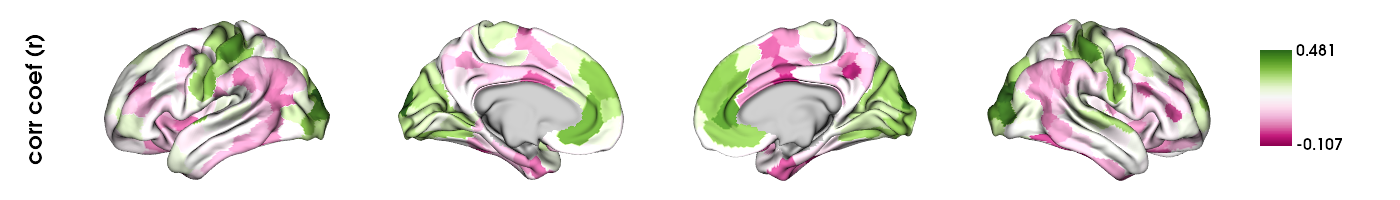

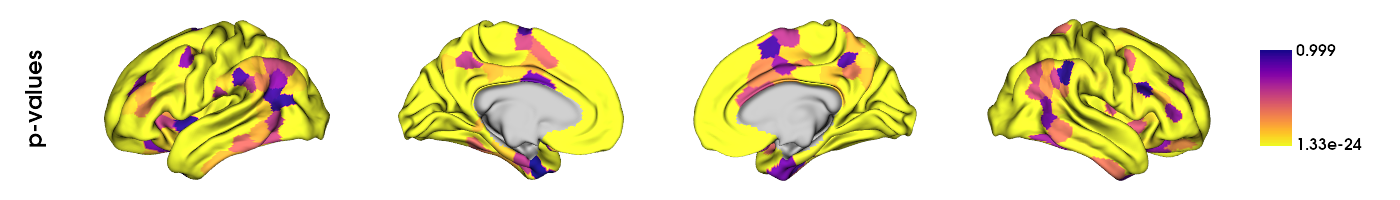

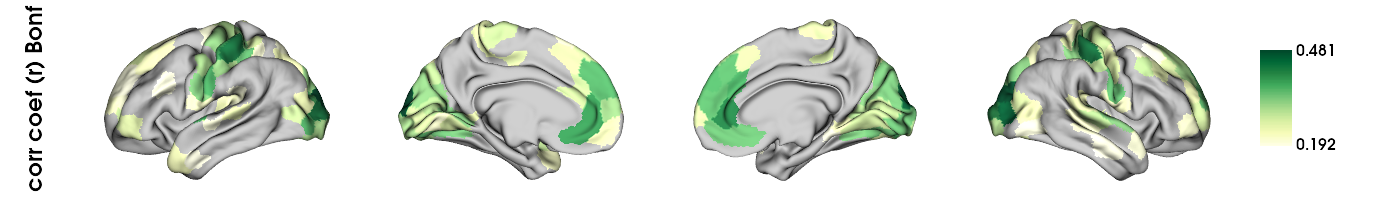

In [153]:
plots_to_display = row_wise_correlation_matrices(x = GSP_mean_ct_cov_matrix, y = GSP_mean_fc_matrix, label_x = 'mean structural GSP', label_y = 'mean functional GSP')
display(*plots_to_display)

### HCP

Significant row-wise correlations between mean structural HCP and mean functional HCP matrices: 315
Significant row-wise correlations between mean structural HCP and mean functional HCP matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): 215


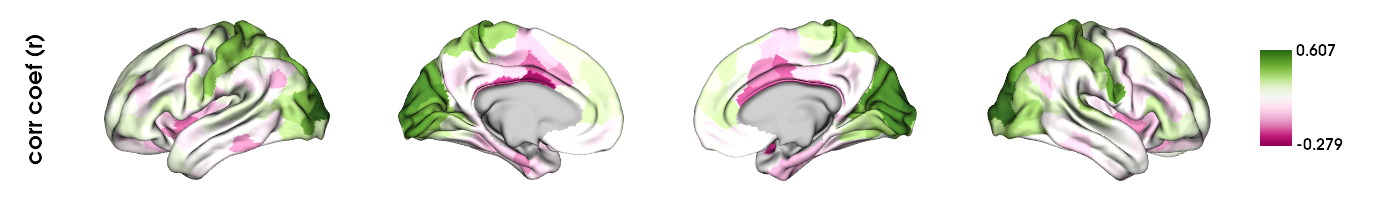

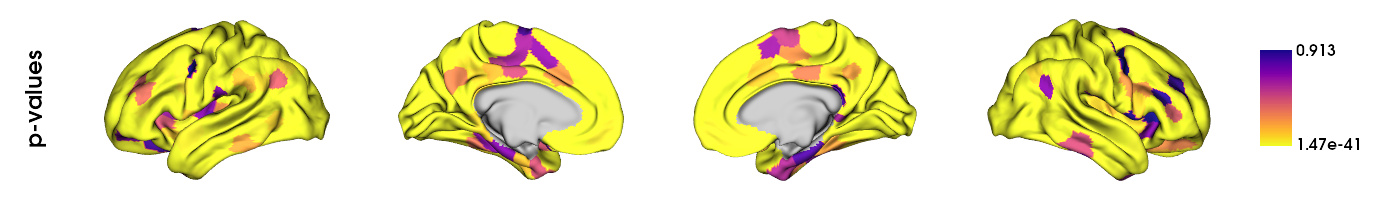

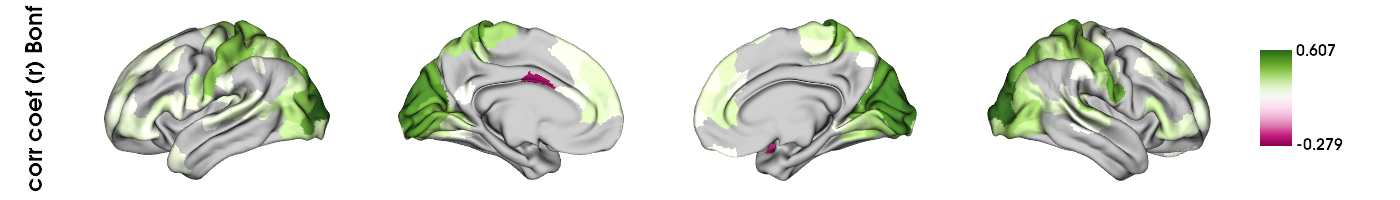

In [154]:
plots_to_display = row_wise_correlation_matrices(x = HCP_mean_ct_cov_matrix, y = HCP_mean_fc_matrix, label_x = 'mean structural HCP', label_y = 'mean functional HCP')
display(*plots_to_display)

## By sex

(this is just exploratory - by curiosity)

### GSP

#### Males

Significant row-wise correlations between mean structural GSP (males) and mean functional GSP (males) matrices: 283
Significant row-wise correlations between mean structural GSP (males) and mean functional GSP (males) matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): 157


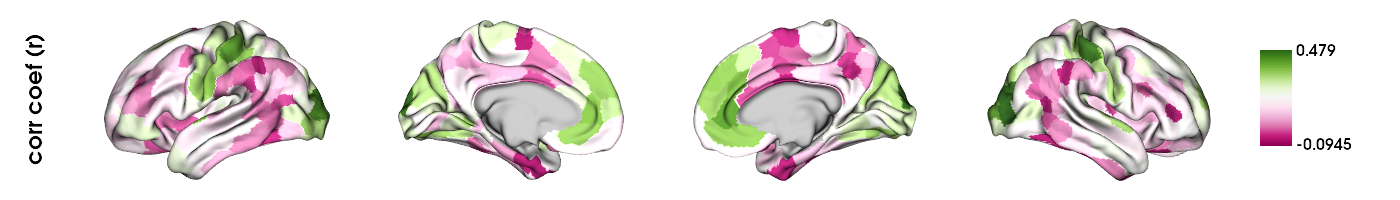

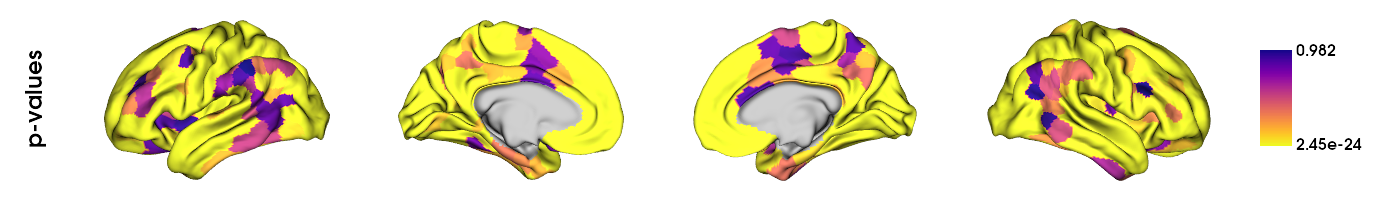

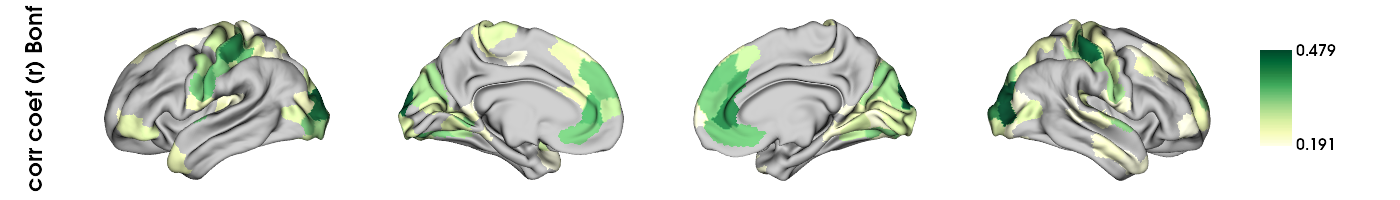

In [155]:
plots_to_display = row_wise_correlation_matrices(x = GSP_mean_ct_cov_matrix_M, y = GSP_mean_fc_matrix_M, label_x = 'mean structural GSP (males)', label_y = 'mean functional GSP (males)')
display(*plots_to_display)

#### Females

Significant row-wise correlations between mean structural GSP (females) and mean functional GSP (females) matrices: 291
Significant row-wise correlations between mean structural GSP (females) and mean functional GSP (females) matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): 163


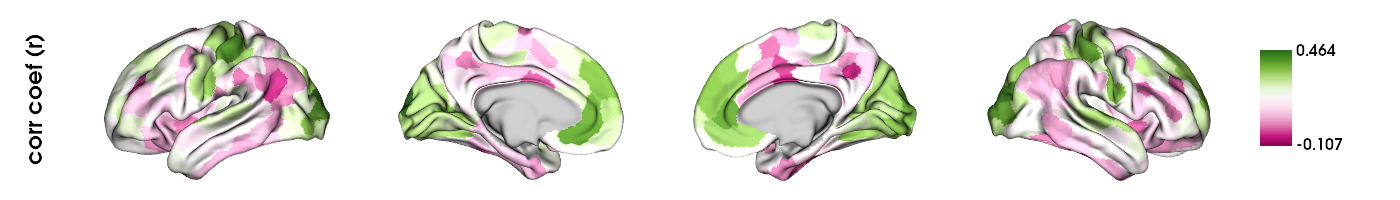

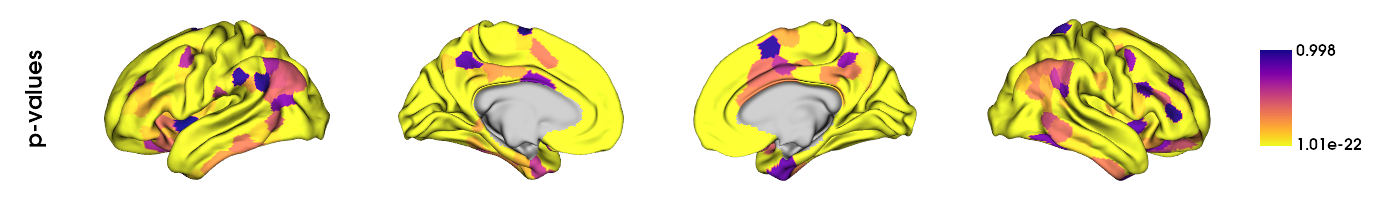

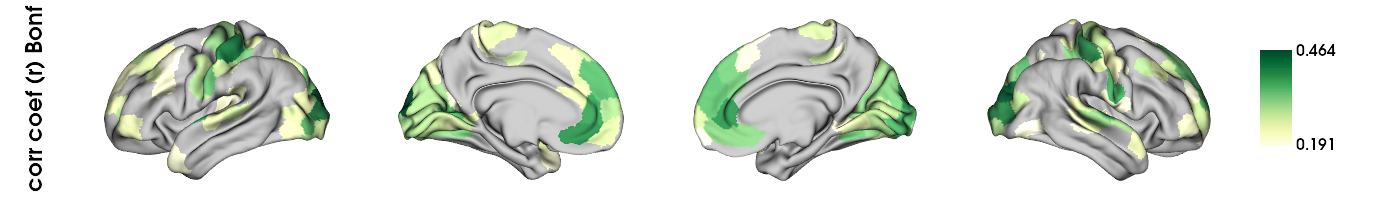

In [156]:
plots_to_display = row_wise_correlation_matrices(x = GSP_mean_ct_cov_matrix_F, y = GSP_mean_fc_matrix_F, label_x = 'mean structural GSP (females)', label_y = 'mean functional GSP (females)')
display(*plots_to_display)

### HCP

#### Males

Significant row-wise correlations between mean structural HCP (males) and mean functional HCP (males) matrices: 297
Significant row-wise correlations between mean structural HCP (males) and mean functional HCP (males) matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): 200


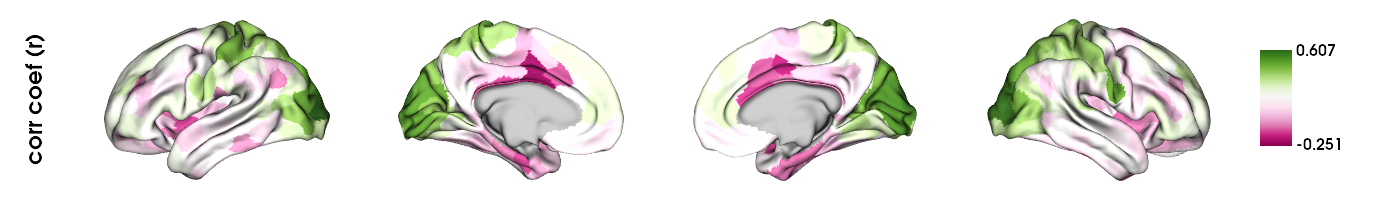

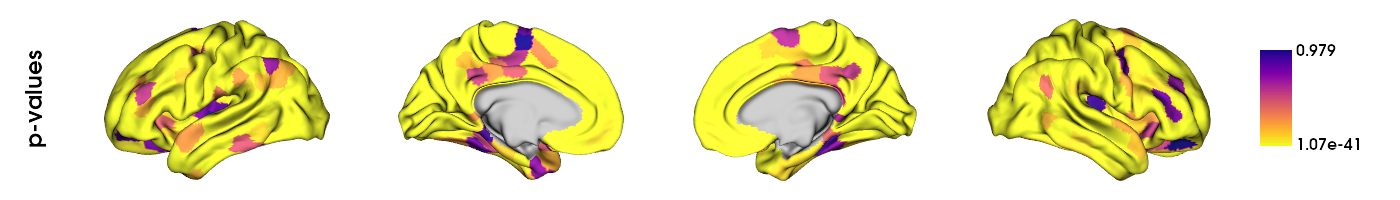

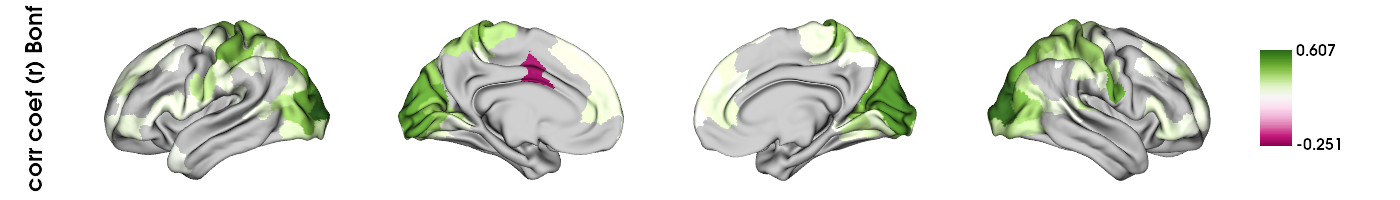

In [157]:
plots_to_display = row_wise_correlation_matrices(x = HCP_mean_ct_cov_matrix_M, y = HCP_mean_fc_matrix_M, label_x = 'mean structural HCP (males)', label_y = 'mean functional HCP (males)')
display(*plots_to_display)

#### Females

Significant row-wise correlations between mean structural HCP (females) and mean functional HCP (females) matrices: 314
Significant row-wise correlations between mean structural HCP (females) and mean functional HCP (females) matrices: (Bonferroni corrected; alpha = 0.05/400 = 0.000125): 210


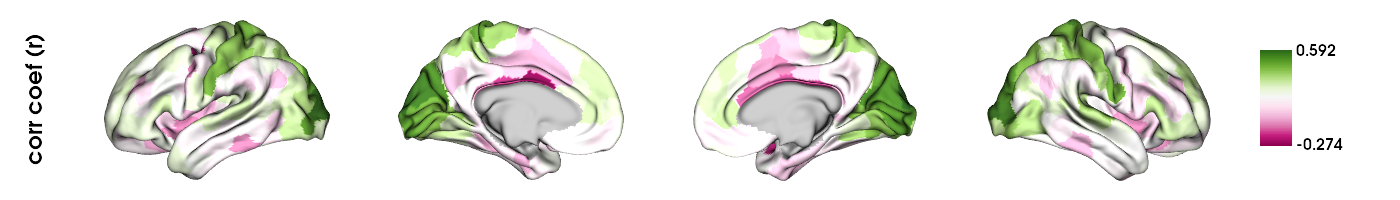

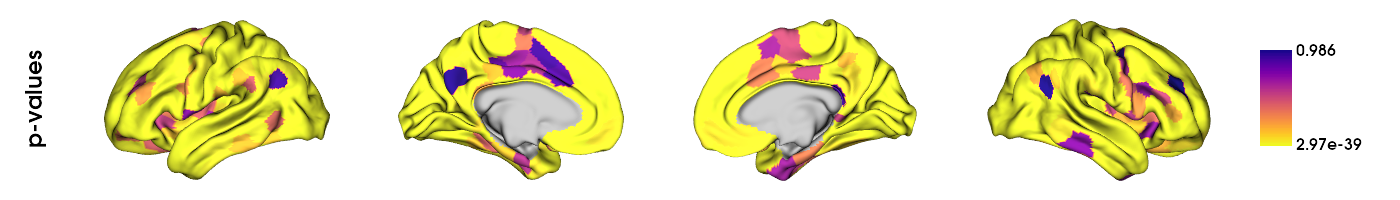

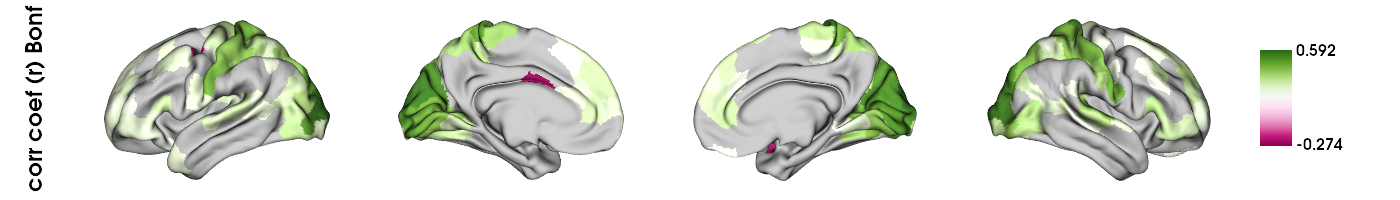

In [158]:
plots_to_display = row_wise_correlation_matrices(x = HCP_mean_ct_cov_matrix_F, y = HCP_mean_fc_matrix_F, label_x = 'mean structural HCP (females)', label_y = 'mean functional HCP (females)')
display(*plots_to_display)

# Structure-function sex difference covariance (covariance of sex effects) 
## Structure: local CT; Function: FC gradients

## GSP

### Correlation t-values

Overall Pearson correlation between GSP sex contrast G2 t-values and GSP sex contrast local CT t-values: r = 0.1; p = 0.049

visual: r = -0.14, p = 0.29
sensory motor: r = -0.04, p = 0.709
dorsal attention: r = 0.22, p = 0.136
ventral attention: r = -0.04, p = 0.779
limbic: r = -0.01, p = 0.979
fronto parietal: r = 0.01, p = 0.922
DMN: r = 0.15, p = 0.164




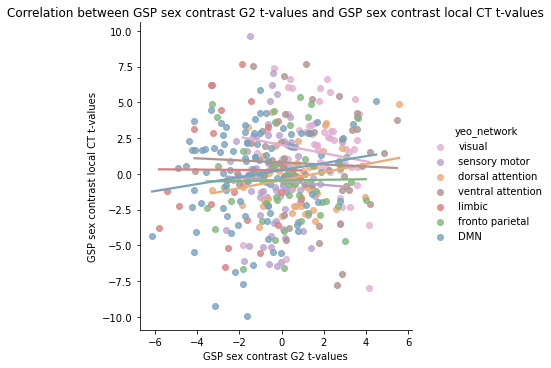

In [145]:
print_plot_corr_networks(x = GSP_R_lm_fc_G2_sex_contrast_res.t_val_sex, y = GSP_R_lm_ct_local_sex_contrast_res.t_val_sex, x_label = 'GSP sex contrast G2 t-values', y_label = 'GSP sex contrast local CT t-values')

#### Spin permutation test (for correlation of t-values)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.218


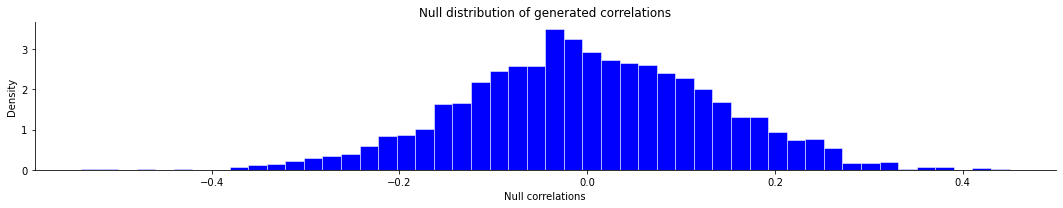

In [146]:
SpinPermutationTest_PearsonCorr_Schaefer400(x = GSP_R_lm_fc_G2_sex_contrast_res.t_val_sex, y = GSP_R_lm_ct_local_sex_contrast_res.t_val_sex)

### Comparing parcels showing statistically significant sex differences between structure and function

Number of parcels that show statistically significant sex differences across datasets: 51
Number of parcels that show statistically significant sex differences in GSP G2 fc only: 54
Number of parcels that show statistically significant sex differences in GSP local CT only: 128
Number of parcels (out of the 51 parcels that show sig sex differences in both datasets) which show sex differences in opposite directions: 22



'Overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant'

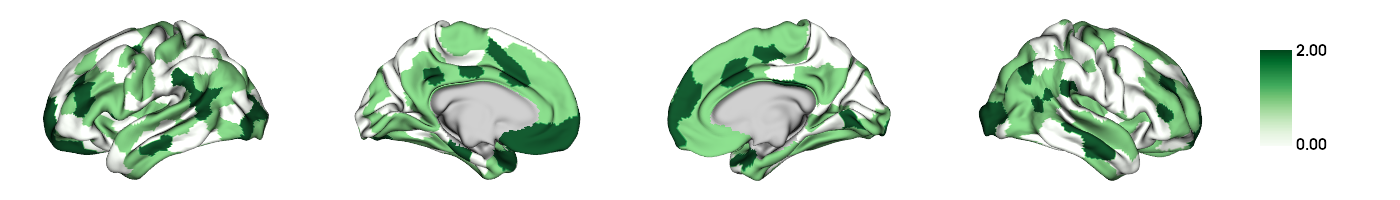

'Which dataset shows significant sex difference: +1 (purple) GSP G2 fc, -1 (brown) = GSP local CT, 0 (white) = both datasets, nan (grey) = not significant in any dataset'

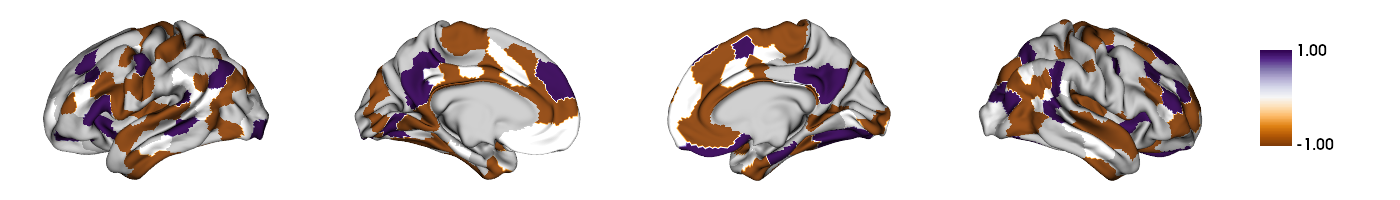

'Parcels showing sex differences in opposite directions'

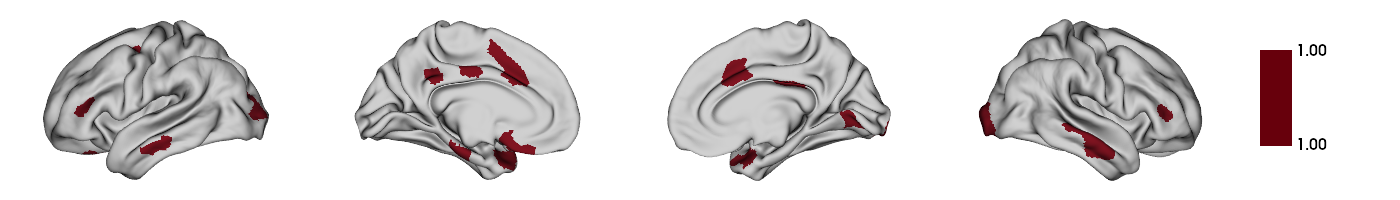

In [147]:
plots_to_display = plot_sig_overlap(reg_res_sample_1 = GSP_R_lm_fc_G2_sex_contrast_res, reg_res_sample_2 = GSP_R_lm_ct_local_sex_contrast_res, sample_1_label = "GSP G2 fc", sample_2_label = "GSP local CT")
display(*plots_to_display)

### Visualizing t-values of sex contrast by network

Minimum positive significant t-value in GSP G2 fc: 2.5
Minimum negative significant t-value in GSP G2 fc: -2.56

Number of positive significant t-values (M > F (gradient loadings)) in GSP G2 fc: 56 -> by network: {'visual': 19, 'sensory motor': 2, 'dorsal attention': 4, 'ventral attention': 19, 'limbic': 0, 'fronto parietal': 8, 'DMN': 4}
Number of negative significant t-values (F > M (gradient loadings)) in GSP G2 fc: 49 -> by network: {'visual': 0, 'sensory motor': 1, 'dorsal attention': 1, 'ventral attention': 1, 'limbic': 11, 'fronto parietal': 6, 'DMN': 29}


Minimum positive significant t-value in GSP local CT: 2.29
Minimum negative significant t-value in GSP local CT: -2.31

Number of positive significant t-values (M > F (gradient loadings)) in GSP local CT: 99 -> by network: {'visual': 25, 'sensory motor': 14, 'dorsal attention': 6, 'ventral attention': 15, 'limbic': 9, 'fronto parietal': 9, 'DMN': 21}
Number of negative significant t-values (F > M (gradient loadings)) in GSP l

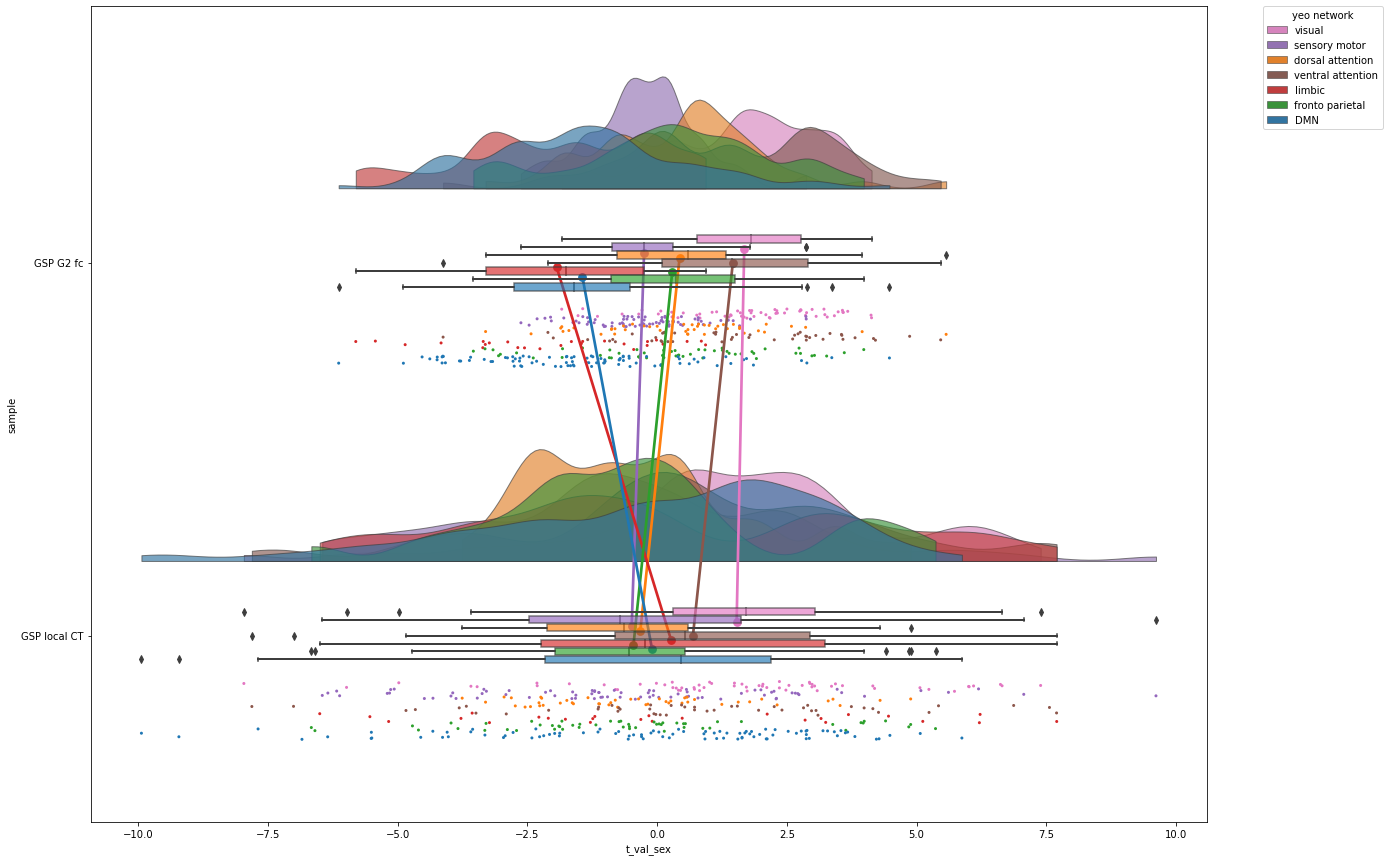

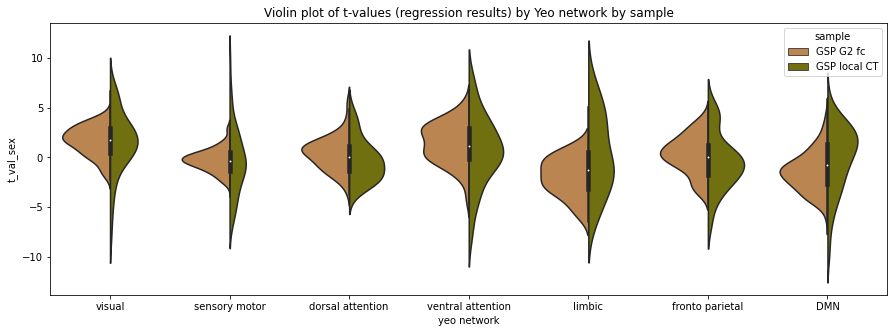

In [148]:
RainCloudPlot_YeoNetworks_SampleComparison_tval(reg_res_sample_1 = GSP_R_lm_fc_G2_sex_contrast_res, reg_res_sample_2 = GSP_R_lm_ct_local_sex_contrast_res, sample_1_label = "GSP G2 fc", sample_2_label = "GSP local CT")

## HCP

### Correlation t-values

Overall Pearson correlation between HCP sex contrast G1 t-values and HCP sex contrast local CT t-values: r = 0.08; p = 0.118

visual: r = -0.25, p = 0.056
sensory motor: r = 0.26, p = 0.021
dorsal attention: r = 0.34, p = 0.02
ventral attention: r = 0.17, p = 0.266
limbic: r = 0.01, p = 0.978
fronto parietal: r = 0.1, p = 0.484
DMN: r = -0.1, p = 0.342




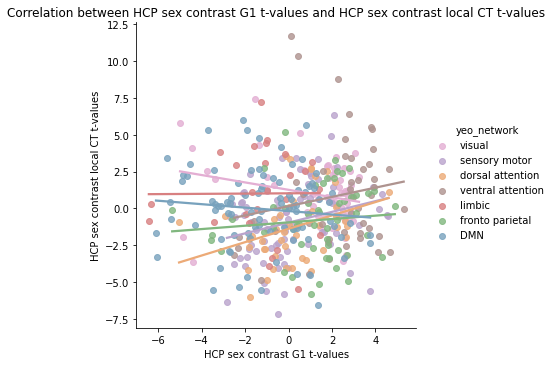

In [149]:
print_plot_corr_networks(x = HCP_R_lmer_fc_G1_sex_contrast_res.t_val_sex, y = HCP_R_lmer_ct_local_sex_contrast_res.t_val_sex, x_label = 'HCP sex contrast G1 t-values', y_label = 'HCP sex contrast local CT t-values')

#### Spin permutation test (for correlation of t-values)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.2605


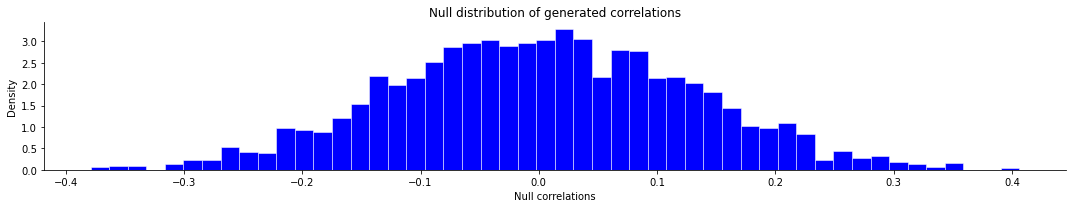

In [150]:
SpinPermutationTest_PearsonCorr_Schaefer400(x = HCP_R_lmer_fc_G1_sex_contrast_res.t_val_sex, y = HCP_R_lmer_ct_local_sex_contrast_res.t_val_sex)

### Comparing parcels showing statistically significant sex differences between structure and function

Number of parcels that show statistically significant sex differences across datasets: 47
Number of parcels that show statistically significant sex differences in HCP G1 fc only: 87
Number of parcels that show statistically significant sex differences in HCP local CT only: 112
Number of parcels (out of the 47 parcels that show sig sex differences in both datasets) which show sex differences in opposite directions: 22



'Overlap of significant sex differences: 2 (dark green): significant in both samples, 1 (light green): significant in one sample, 0: not significant'

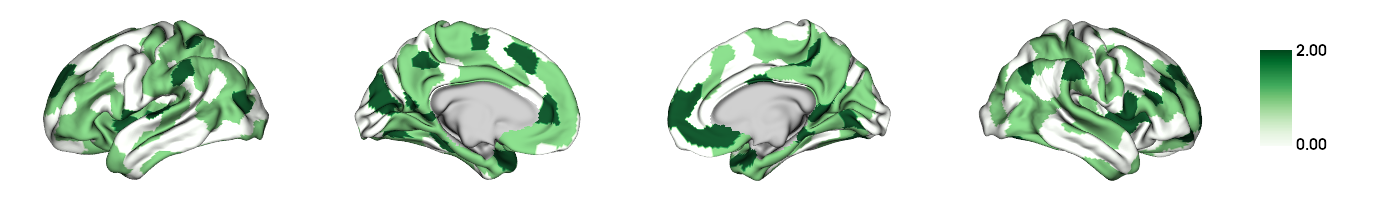

'Which dataset shows significant sex difference: +1 (purple) HCP G1 fc, -1 (brown) = HCP local CT, 0 (white) = both datasets, nan (grey) = not significant in any dataset'

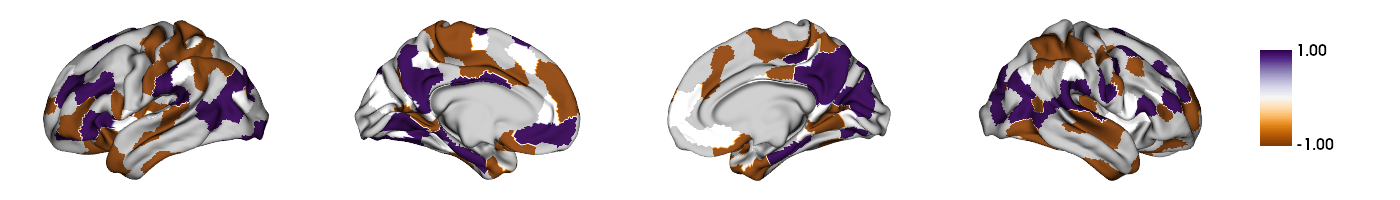

'Parcels showing sex differences in opposite directions'

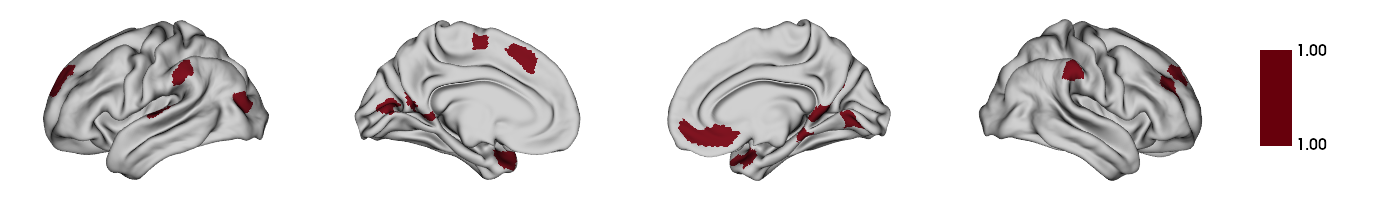

In [151]:
plots_to_display = plot_sig_overlap(reg_res_sample_1 = HCP_R_lmer_fc_G1_sex_contrast_res, reg_res_sample_2 = HCP_R_lmer_ct_local_sex_contrast_res, sample_1_label = "HCP G1 fc", sample_2_label = "HCP local CT")
display(*plots_to_display)

### Visualizing t-values of sex contrast by network

Minimum positive significant t-value in HCP G1 fc: 2.41
Minimum negative significant t-value in HCP G1 fc: -2.43

Number of positive significant t-values (M > F (gradient loadings)) in HCP G1 fc: 82 -> by network: {'visual': 23, 'sensory motor': 8, 'dorsal attention': 4, 'ventral attention': 29, 'limbic': 0, 'fronto parietal': 13, 'DMN': 5}
Number of negative significant t-values (F > M (gradient loadings)) in HCP G1 fc: 52 -> by network: {'visual': 6, 'sensory motor': 5, 'dorsal attention': 2, 'ventral attention': 1, 'limbic': 5, 'fronto parietal': 5, 'DMN': 28}


Minimum positive significant t-value in HCP local CT: 2.35
Minimum negative significant t-value in HCP local CT: -2.34

Number of positive significant t-values (M > F (gradient loadings)) in HCP local CT: 74 -> by network: {'visual': 16, 'sensory motor': 9, 'dorsal attention': 5, 'ventral attention': 14, 'limbic': 10, 'fronto parietal': 6, 'DMN': 14}
Number of negative significant t-values (F > M (gradient loadings)) in HCP 

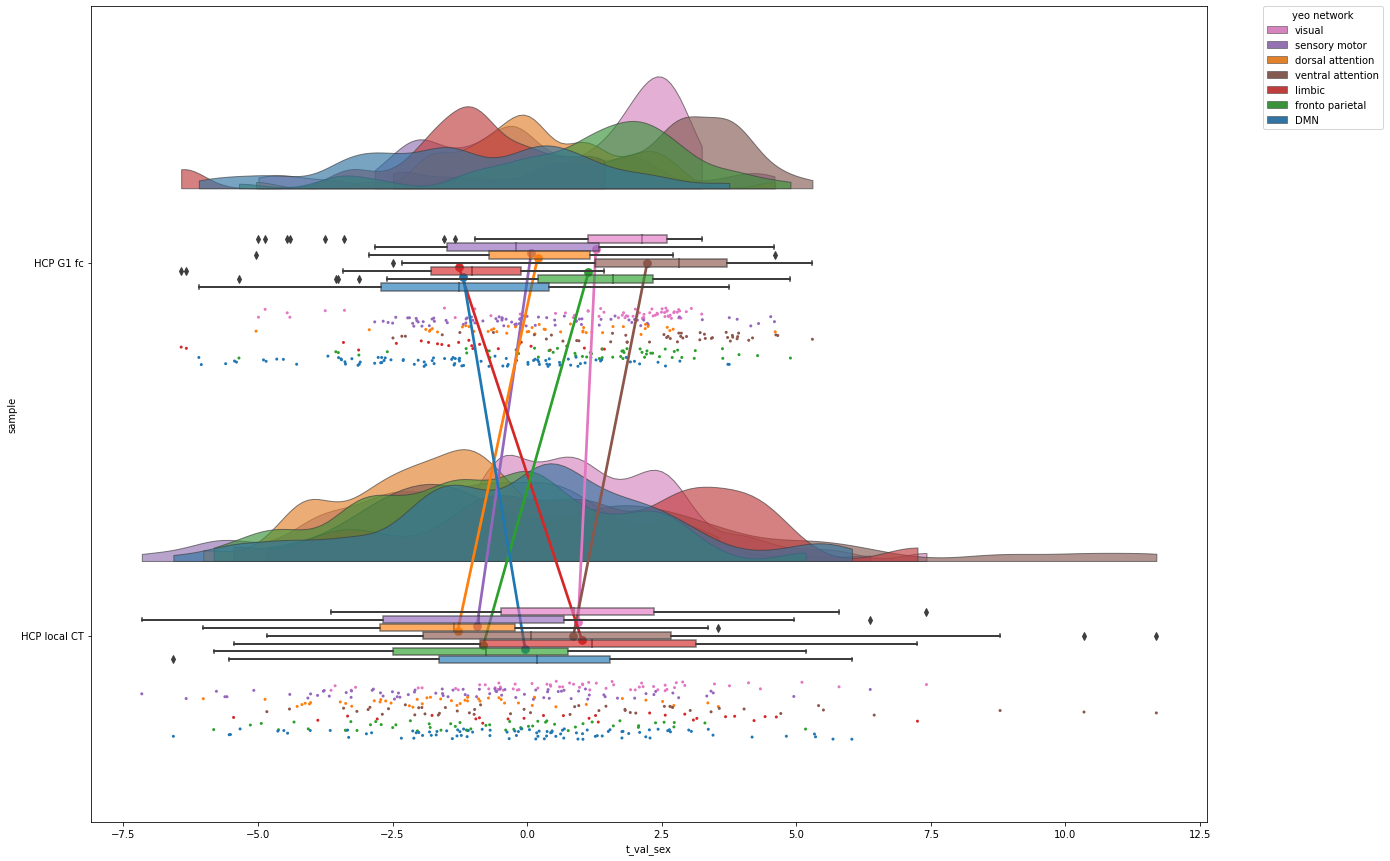

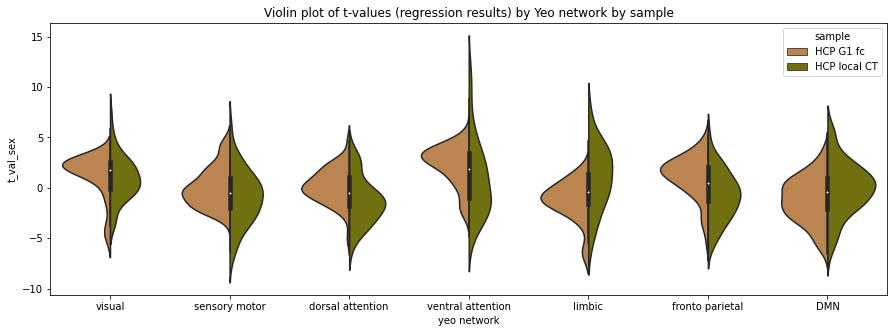

In [152]:
RainCloudPlot_YeoNetworks_SampleComparison_tval(reg_res_sample_1 = HCP_R_lmer_fc_G1_sex_contrast_res, reg_res_sample_2 = HCP_R_lmer_ct_local_sex_contrast_res, sample_1_label = "HCP G1 fc", sample_2_label = "HCP local CT")

# ------------------ TO DO: --------------------
# Structure-function sex difference covariance (covariance of sex effects) 
## Structure: CT gradients; Function: FC gradients

In [ ]:
copy paste the above